# Data Ingestion, Cleaning, Integration and Analysis

In [75]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import unicodedata
import re
import os
import webbrowser 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import pprint
import warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# File paths
heat_pump_fp = './Data/energy_meter_data.parquet'
isolar_fp = './Data/data_isolarcloud_isolarcloud_all_inverter_master.parquet'
location_map_fp = './Data/Solar_id_location_mapping.csv'

# Read data
heatpump_df = pd.read_parquet(heat_pump_fp)
isolar_df = pd.read_parquet(isolar_fp)
location_df = pd.read_csv(location_map_fp, encoding='latin1')


# Rename the 'hour' column in heatpump_df to 'timestamp'
heatpump_df = heatpump_df.rename(columns={"hour": "timestamp"})

# Standardize datetime columns
# Make sure all datetime columns are timezone-aware in UTC
heatpump_df['timestamp'] = pd.to_datetime(heatpump_df['timestamp'], utc=True)
isolar_df['timestamp'] = pd.to_datetime(isolar_df['timestamp'], utc=True)

# sanity check
print(f"Heatpump time dtype: {heatpump_df['timestamp'].dtype}")
print(f"Isolar time dtype: {isolar_df['timestamp'].dtype}")

Heatpump time dtype: datetime64[ns, UTC]
Isolar time dtype: datetime64[ns, UTC]


# Inspect initial data

In [3]:
# Directory to store HTML files
dir_path = os.path.abspath("./Data/HTML")
os.makedirs(dir_path, exist_ok=True)

# Generate profiles
profile_hp = ProfileReport(heatpump_df, title="Heat Pump Data Report", explorative=True)
profile_iso = ProfileReport(isolar_df, title="Solar Inverter Data Report", explorative=True)
profile_loc = ProfileReport(location_df, title="Location Mapping Report", explorative=True)

# Save profiles
profile_hp.to_file(os.path.join(dir_path, "heatpump_profile.html"))
profile_iso.to_file(os.path.join(dir_path, "isolar_profile.html"))
profile_loc.to_file(os.path.join(dir_path, "location_mapping_profile.html"))

# Create a Dropdown-Driven Dashboard HTML
dashboard_html = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Combined Data Profiling Dashboard</title>
    <script>
        function updateIframe() {{
            var selection = document.getElementById("reportSelector").value;
            document.getElementById("reportFrame").src = selection;
        }}
    </script>
</head>
<body>
    <h1>Data Report Dashboard</h1>
    <label for="reportSelector">Choose a dataset report:</label>
    <select id="reportSelector" onchange="updateIframe()">
        <option value="heatpump_profile.html">Heat Pump Data</option>
        <option value="isolar_profile.html">Isolar Inverter Data</option>
        <option value="location_mapping_profile.html">Location Mapping</option>
    </select>

    <iframe id="reportFrame" src="heatpump_profile.html" width="100%" height="800px" style="border:none;"></iframe>
</body>
</html>
"""

# Save dashboard HTML
combined_dashboard_path = os.path.join(dir_path, "combined_dashboard.html")
with open(combined_dashboard_path, "w") as f:
    f.write(dashboard_html)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 59.06it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:34<00:00,  2.29it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 283.77it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Quick overview of the data
webbrowser.open(f"file://{os.path.abspath(combined_dashboard_path)}")

True

In [5]:
heatpump_df.head()

,dst,timestamp,energy_kWh_a,energy_kWh_b,energy_kWh_c,total_energy_kWh
0,abrinken-1-jonsered/events,2024-11-08 09:00:00+00:00,0.012567,0.005851,0.004446,0.022864
1,abrinken-1-jonsered/events,2024-11-08 10:00:00+00:00,0.193559,0.187162,0.160569,0.541290
2,abrinken-1-jonsered/events,2024-11-08 11:00:00+00:00,0.186135,0.181604,0.156360,0.524099
3,abrinken-1-jonsered/events,2024-11-08 12:00:00+00:00,0.169495,0.158407,0.136902,0.464804
4,abrinken-1-jonsered/events,2024-11-08 13:00:00+00:00,0.170898,0.160296,0.138029,0.469223


In [6]:
isolar_df.head()

,site_id,timestamp,active_power,total_dc_power,total_reactive_power,total_apparent_power,load_power,battery_charging_power,battery_discharging_power,purchased_power,...,backup_power_total,backup_current_phase_a,backup_current_phase_b,backup_current_phase_c,backup_voltage_phase_a,backup_voltage_phase_b,backup_voltage_phase_c,meter_voltage_phase_a,meter_voltage_phase_b,meter_voltage_phase_c
0,5596691,2024-08-21 16:30:00+00:00,0.0,0.0,0.0,0.0,369.0,0.0,92.0,373.0,...,2.0,0.2,0.2,0.2,235.4,236.6,234.6,236.3,236.4,235.5
1,5596691,2024-08-21 16:35:00+00:00,381.0,486.0,0.0,360.0,259.0,0.0,0.0,0.0,...,16.0,0.2,0.2,0.2,234.0,237.0,234.5,235.4,236.1,235.0
2,5596691,2024-08-21 16:40:00+00:00,355.0,280.0,1.0,415.0,365.0,0.0,213.0,0.0,...,15.0,0.2,0.2,0.2,234.7,236.6,233.6,235.8,235.9,235.1
3,5596691,2024-08-21 16:45:00+00:00,272.0,318.0,0.0,251.0,311.0,0.0,85.0,0.0,...,12.0,0.2,0.2,0.2,234.8,237.5,234.7,236.2,236.8,235.1
4,5596691,2024-08-21 16:50:00+00:00,303.0,253.0,0.0,299.0,286.0,0.0,187.0,0.0,...,11.0,0.2,0.2,0.2,233.5,236.5,232.6,235.1,235.3,234.1


In [7]:
location_df.head()

,Location,Open Solar Project ID
0,"Åbrinken 1, Jonsered",4929671
1,"Blixterboda 144, Frövi",5187934
2,"Dalbyvägen 9, Bettna",5161140
3,"Ekedalen Solhem None, Tidaholm",5483352
4,"Gamlarpsvägen 31, Nässjö",5283693


In [8]:
print(heatpump_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79498 entries, 0 to 79497
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   dst               79498 non-null  object             
 1   timestamp         79498 non-null  datetime64[ns, UTC]
 2   energy_kWh_a      79498 non-null  float64            
 3   energy_kWh_b      79498 non-null  float64            
 4   energy_kWh_c      79498 non-null  float64            
 5   total_energy_kWh  79498 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), object(1)
memory usage: 3.6+ MB
None


In [9]:
print(isolar_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416116 entries, 0 to 1416115
Data columns (total 80 columns):
 #   Column                       Non-Null Count    Dtype              
---  ------                       --------------    -----              
 0   site_id                      1416116 non-null  object             
 1   timestamp                    1416116 non-null  datetime64[ns, UTC]
 2   active_power                 1039438 non-null  float64            
 3   total_dc_power               1039438 non-null  float64            
 4   total_reactive_power         1039504 non-null  float64            
 5   total_apparent_power         1039460 non-null  float64            
 6   load_power                   1034777 non-null  float64            
 7   battery_charging_power       1016016 non-null  float64            
 8   battery_discharging_power    1016016 non-null  float64            
 9   purchased_power              1032362 non-null  float64            
 10  feed_in_power     

In [10]:
print(location_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Location               46 non-null     object
 1   Open Solar Project ID  46 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 868.0+ bytes
None


In [11]:
print(heatpump_df.describe())

       energy_kWh_a  energy_kWh_b  energy_kWh_c  total_energy_kWh
count  79498.000000  79498.000000  79498.000000      79498.000000
mean       0.680519      0.497816      0.481581          1.659917
std        6.455258      6.096818      6.189511         18.292141
min        0.000000      0.000000      0.000000          0.000000
25%        0.199437      0.074714      0.130901          0.592869
50%        0.416060      0.328305      0.316324          1.124995
75%        0.768624      0.600341      0.552012          1.838992
max     1100.637270   1085.524215   1076.332862       3262.494347


In [12]:
print(isolar_df.describe())

       active_power  total_dc_power  total_reactive_power  \
count  1.039438e+06    1.039438e+06          1.039504e+06   
mean   3.900865e+02    4.762608e+02         -6.309576e-01   
std    1.532868e+03    1.307170e+03          1.644639e+01   
min   -1.697300e+04    0.000000e+00         -5.770000e+02   
25%   -6.100000e+01    0.000000e+00          0.000000e+00   
50%   -4.900000e+01    0.000000e+00          0.000000e+00   
75%    1.730000e+02    1.820000e+02          0.000000e+00   
max    1.503200e+04    1.544900e+04          4.280000e+02   

       total_apparent_power    load_power  battery_charging_power  \
count          1.039460e+06  1.034777e+06            1.016016e+06   
mean           5.614223e+02  2.523701e+03            6.636690e+01   
std            1.482154e+03  2.391148e+03            7.371823e+02   
min            0.000000e+00  0.000000e+00            0.000000e+00   
25%            5.400000e+01  9.310000e+02            0.000000e+00   
50%            6.600000e+01  1.93000

In [13]:
print(location_df.describe())

       Open Solar Project ID
count           4.600000e+01
mean            5.554168e+06
std             4.514469e+05
min             4.419243e+06
25%             5.211434e+06
50%             5.465299e+06
75%             5.852479e+06
max             6.384024e+06


In [14]:
heatpump_df.loc[~heatpump_df.index.duplicated(), :]

,dst,timestamp,energy_kWh_a,energy_kWh_b,energy_kWh_c,total_energy_kWh
0,abrinken-1-jonsered/events,2024-11-08 09:00:00+00:00,0.012567,0.005851,0.004446,0.022864
1,abrinken-1-jonsered/events,2024-11-08 10:00:00+00:00,0.193559,0.187162,0.160569,0.541290
2,abrinken-1-jonsered/events,2024-11-08 11:00:00+00:00,0.186135,0.181604,0.156360,0.524099
3,abrinken-1-jonsered/events,2024-11-08 12:00:00+00:00,0.169495,0.158407,0.136902,0.464804
4,abrinken-1-jonsered/events,2024-11-08 13:00:00+00:00,0.170898,0.160296,0.138029,0.469223
...,...,...,...,...,...,...
79493,vrebrovagen-4-sagmyra/events,2025-04-03 02:00:00+00:00,0.000000,0.000000,0.006358,0.006358
79494,vrebrovagen-4-sagmyra/events,2025-04-03 03:00:00+00:00,0.000000,0.000000,0.006453,0.006453
79495,vrebrovagen-4-sagmyra/events,2025-04-03 04:00:00+00:00,0.000000,0.000000,0.005780,0.005780
79496,vrebrovagen-4-sagmyra/events,2025-04-03 05:00:00+00:00,0.000000,0.000000,0.121115,0.121115


In [15]:
isolar_df.loc[~isolar_df.index.duplicated(), :]

,site_id,timestamp,active_power,total_dc_power,total_reactive_power,total_apparent_power,load_power,battery_charging_power,battery_discharging_power,purchased_power,...,backup_power_total,backup_current_phase_a,backup_current_phase_b,backup_current_phase_c,backup_voltage_phase_a,backup_voltage_phase_b,backup_voltage_phase_c,meter_voltage_phase_a,meter_voltage_phase_b,meter_voltage_phase_c
0,5596691,2024-08-21 16:30:00+00:00,0.0,0.0,0.0,0.0,369.0,0.0,92.0,373.0,...,2.0,0.2,0.2,0.2,235.4,236.6,234.6,236.3,236.4,235.5
1,5596691,2024-08-21 16:35:00+00:00,381.0,486.0,0.0,360.0,259.0,0.0,0.0,0.0,...,16.0,0.2,0.2,0.2,234.0,237.0,234.5,235.4,236.1,235.0
2,5596691,2024-08-21 16:40:00+00:00,355.0,280.0,1.0,415.0,365.0,0.0,213.0,0.0,...,15.0,0.2,0.2,0.2,234.7,236.6,233.6,235.8,235.9,235.1
3,5596691,2024-08-21 16:45:00+00:00,272.0,318.0,0.0,251.0,311.0,0.0,85.0,0.0,...,12.0,0.2,0.2,0.2,234.8,237.5,234.7,236.2,236.8,235.1
4,5596691,2024-08-21 16:50:00+00:00,303.0,253.0,0.0,299.0,286.0,0.0,187.0,0.0,...,11.0,0.2,0.2,0.2,233.5,236.5,232.6,235.1,235.3,234.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416111,5778743,2025-04-02 23:40:00+00:00,1.0,26.0,0.0,1.0,0.0,0.0,80.0,0.0,...,0.0,0.1,0.1,0.1,4.2,2.6,2.6,239.1,238.8,238.5
1416112,5778743,2025-04-02 23:45:00+00:00,1.0,26.0,0.0,1.0,0.0,0.0,80.0,0.0,...,0.0,0.1,0.1,0.1,4.2,2.6,2.6,239.1,238.8,239.6
1416113,5778743,2025-04-02 23:50:00+00:00,1.0,26.0,0.0,1.0,0.0,0.0,80.0,0.0,...,0.0,0.1,0.1,0.1,4.2,2.6,2.6,239.1,238.8,239.6
1416114,5778743,2025-04-02 23:55:00+00:00,1.0,26.0,0.0,1.0,0.0,0.0,80.0,0.0,...,0.0,0.1,0.1,0.1,4.2,2.6,2.6,239.1,238.6,239.6


In [16]:
location_df.loc[~location_df.index.duplicated(), :]

,Location,Open Solar Project ID
0,"Åbrinken 1, Jonsered",4929671
1,"Blixterboda 144, Frövi",5187934
2,"Dalbyvägen 9, Bettna",5161140
3,"Ekedalen Solhem None, Tidaholm",5483352
4,"Gamlarpsvägen 31, Nässjö",5283693
5,"Gärdesvägen 2, Trångsund",5159356
6,"Goddalen 4, Rönnäng",5819052
7,"Husbyvägen 5, Uppsala",5946924
8,"Kärleksstigen 6, Kisa",5464386
9,"Klittervägen 8, Åhus",5302839


In [17]:
heatpump_df.isnull().sum()

dst                 0
timestamp           0
energy_kWh_a        0
energy_kWh_b        0
energy_kWh_c        0
total_energy_kWh    0
dtype: int64

In [18]:
isolar_df.isnull().sum()

site_id                        0
timestamp                      0
active_power              376678
total_dc_power            376678
total_reactive_power      376612
                           ...  
backup_voltage_phase_b    376652
backup_voltage_phase_c    376652
meter_voltage_phase_a     383734
meter_voltage_phase_b     383734
meter_voltage_phase_c     383734
Length: 80, dtype: int64

In [19]:
location_df.isnull().sum()

Location                 0
Open Solar Project ID    0
dtype: int64

In [20]:
df1 = heatpump_df
df1['Month'] = pd.to_datetime(heatpump_df['timestamp']).dt.month
df1['Year'] = pd.to_datetime(heatpump_df['timestamp']).dt.year
df1['Date'] = pd.to_datetime(heatpump_df['timestamp']).dt.date
df1['Time'] = pd.to_datetime(heatpump_df['timestamp']).dt.time
df1['Week'] = pd.to_datetime(heatpump_df['timestamp']).dt.isocalendar().week
df1['Day'] = pd.to_datetime(heatpump_df['timestamp']).dt.day_name()
df1 = heatpump_df.set_index('timestamp')
df1.index = pd.to_datetime(df1.index)
df1.head()

,dst,energy_kWh_a,energy_kWh_b,energy_kWh_c,total_energy_kWh,Month,Year,Date,Time,Week,Day
timestamp,,,,,,,,,,,
2024-11-08 09:00:00+00:00,abrinken-1-jonsered/events,0.012567,0.005851,0.004446,0.022864,11,2024,2024-11-08,09:00:00,45,Friday
2024-11-08 10:00:00+00:00,abrinken-1-jonsered/events,0.193559,0.187162,0.160569,0.541290,11,2024,2024-11-08,10:00:00,45,Friday
2024-11-08 11:00:00+00:00,abrinken-1-jonsered/events,0.186135,0.181604,0.156360,0.524099,11,2024,2024-11-08,11:00:00,45,Friday
2024-11-08 12:00:00+00:00,abrinken-1-jonsered/events,0.169495,0.158407,0.136902,0.464804,11,2024,2024-11-08,12:00:00,45,Friday
2024-11-08 13:00:00+00:00,abrinken-1-jonsered/events,0.170898,0.160296,0.138029,0.469223,11,2024,2024-11-08,13:00:00,45,Friday


In [21]:
df2 = isolar_df
df2['Month'] = pd.to_datetime(isolar_df['timestamp']).dt.month
df2['Year'] = pd.to_datetime(isolar_df['timestamp']).dt.year
df2['Date'] = pd.to_datetime(isolar_df['timestamp']).dt.date
df2['Time'] = pd.to_datetime(isolar_df['timestamp']).dt.time
df2['Week'] = pd.to_datetime(isolar_df['timestamp']).dt.isocalendar().week
df2['Day'] = pd.to_datetime(isolar_df['timestamp']).dt.day_name()
df2 = isolar_df.set_index('timestamp')
df2.index = pd.to_datetime(df2.index)
df2.head()

,site_id,active_power,total_dc_power,total_reactive_power,total_apparent_power,load_power,battery_charging_power,battery_discharging_power,purchased_power,feed_in_power,...,backup_voltage_phase_c,meter_voltage_phase_a,meter_voltage_phase_b,meter_voltage_phase_c,Month,Year,Date,Time,Week,Day
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-08-21 16:30:00+00:00,5596691,0.0,0.0,0.0,0.0,369.0,0.0,92.0,373.0,0.0,...,234.6,236.3,236.4,235.5,8,2024,2024-08-21,16:30:00,34,Wednesday
2024-08-21 16:35:00+00:00,5596691,381.0,486.0,0.0,360.0,259.0,0.0,0.0,0.0,0.0,...,234.5,235.4,236.1,235.0,8,2024,2024-08-21,16:35:00,34,Wednesday
2024-08-21 16:40:00+00:00,5596691,355.0,280.0,1.0,415.0,365.0,0.0,213.0,0.0,0.0,...,233.6,235.8,235.9,235.1,8,2024,2024-08-21,16:40:00,34,Wednesday
2024-08-21 16:45:00+00:00,5596691,272.0,318.0,0.0,251.0,311.0,0.0,85.0,0.0,0.0,...,234.7,236.2,236.8,235.1,8,2024,2024-08-21,16:45:00,34,Wednesday
2024-08-21 16:50:00+00:00,5596691,303.0,253.0,0.0,299.0,286.0,0.0,187.0,0.0,0.0,...,232.6,235.1,235.3,234.1,8,2024,2024-08-21,16:50:00,34,Wednesday


In [22]:
df1['Date'].min()

datetime.date(2024, 10, 10)

In [23]:
df1['Date'].max()

datetime.date(2025, 4, 4)

In [24]:
df2['Date'].min()

datetime.date(2024, 8, 21)

In [25]:
df2['Date'].max()

datetime.date(2025, 4, 3)

In [26]:
# unique Years
print(df1.Year.unique(),"\n")
print("Unique Years : ",df1.Year.nunique())

[2024 2025] 

Unique Years :  2


In [27]:
# unique Years
print(df2.Year.unique(),"\n")
print("Unique Years : ",df2.Year.nunique())

[2024 2025] 

Unique Years :  2


# Energy Consumption Each Year

Text(0.5, 1.0, 'Energy Consumption According to Year')

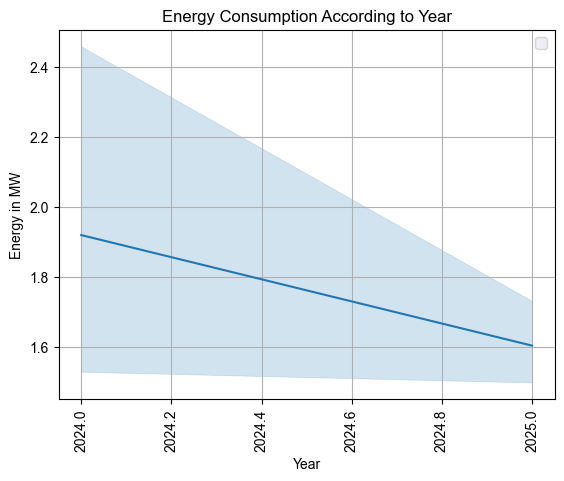

In [28]:
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

style.use('ggplot')

sns.lineplot(x="Year", y="total_energy_kWh", data=heatpump_df)
sns.set(rc={'figure.figsize':(15,6)})

plt.xlabel("Year")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)


plt.title("Energy Consumption According to Year")

# Energy with respect to Time

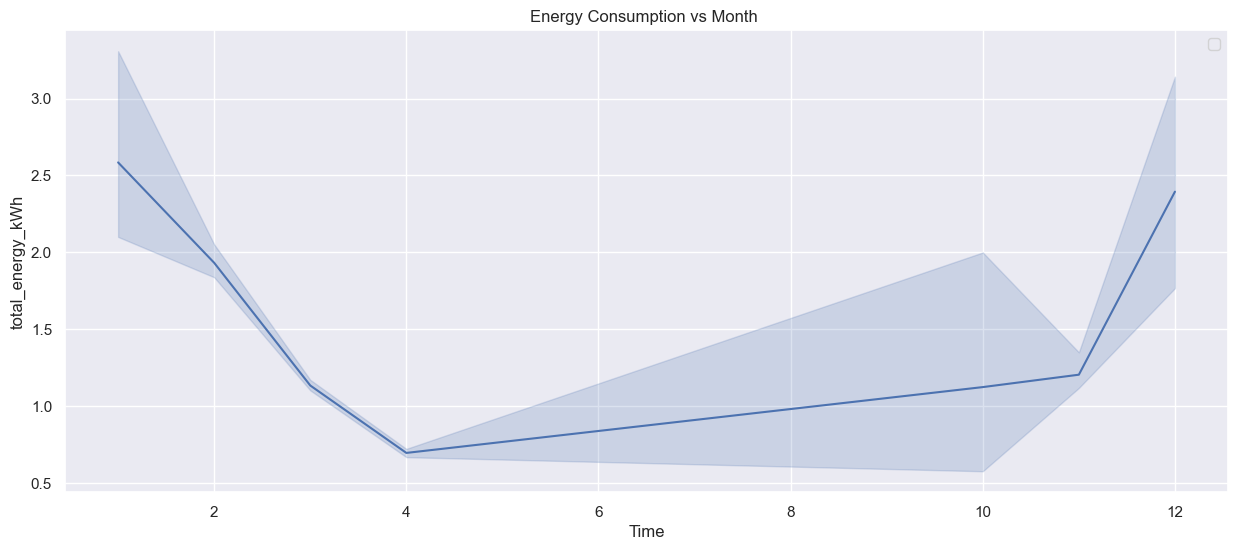

In [29]:
fig = plt.figure()
ax1= fig.add_subplot(111)

sns.lineplot(x=heatpump_df["Month"],y=heatpump_df["total_energy_kWh"], data=heatpump_df)
plt.title("Energy Consumption vs Month ")
plt.xlabel("Time")
plt.grid(True, alpha=1)
plt.legend()

In [30]:
print(f"Number of missing values in heatpump_df: {heatpump_df.isnull().sum()}")
print(100*'-')
print(f"Number of missing values in isolar_df: {isolar_df.isnull().sum()}")
print(100*'-')
print(f"Number of missing values in location_df: {location_df.isnull().sum()}")

Number of missing values in heatpump_df: dst                 0
timestamp           0
energy_kWh_a        0
energy_kWh_b        0
energy_kWh_c        0
total_energy_kWh    0
Month               0
Year                0
Date                0
Time                0
Week                0
Day                 0
dtype: int64
----------------------------------------------------------------------------------------------------
Number of missing values in isolar_df: site_id                      0
timestamp                    0
active_power            376678
total_dc_power          376678
total_reactive_power    376612
                         ...  
Year                         0
Date                         0
Time                         0
Week                         0
Day                          0
Length: 86, dtype: int64
----------------------------------------------------------------------------------------------------
Number of missing values in location_df: Location                 0
Open So

In [31]:
# Count the number of duplicated rows
num_duplicates = heatpump_df.duplicated().sum()

# Print the number of duplicated rows
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


In [ ]:
num_duplicates = isolar_df.duplicated().sum()

print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


In [ ]:
num_duplicates = location_df.duplicated().sum()

print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


In [ ]:
missing_values = heatpump_df.isna().sum()

print(f"Number of missing rows: {missing_values}")

Number of missing rows: dst                 0
timestamp           0
energy_kWh_a        0
energy_kWh_b        0
energy_kWh_c        0
total_energy_kWh    0
Month               0
Year                0
Date                0
Time                0
Week                0
Day                 0
dtype: int64


In [ ]:
missing_values = isolar_df.isna().sum()

print(f"Number of missing rows: {missing_values}")

Number of missing rows: site_id                      0
timestamp                    0
active_power            376678
total_dc_power          376678
total_reactive_power    376612
                         ...  
Year                         0
Date                         0
Time                         0
Week                         0
Day                          0
Length: 86, dtype: int64


In [ ]:
missing_values = location_df.isna().sum()

print(f"Number of missing rows: {missing_values}")

Number of missing rows: Location                 0
Open Solar Project ID    0
dtype: int64


In [37]:
print(heatpump_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79498 entries, 0 to 79497
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   dst               79498 non-null  object             
 1   timestamp         79498 non-null  datetime64[ns, UTC]
 2   energy_kWh_a      79498 non-null  float64            
 3   energy_kWh_b      79498 non-null  float64            
 4   energy_kWh_c      79498 non-null  float64            
 5   total_energy_kWh  79498 non-null  float64            
 6   Month             79498 non-null  int32              
 7   Year              79498 non-null  int32              
 8   Date              79498 non-null  object             
 9   Time              79498 non-null  object             
 10  Week              79498 non-null  UInt32             
 11  Day               79498 non-null  object             
dtypes: UInt32(1), datetime64[ns, UTC](1), float64(4), int32(2), 

In [38]:
print(isolar_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416116 entries, 0 to 1416115
Data columns (total 86 columns):
 #   Column                       Non-Null Count    Dtype              
---  ------                       --------------    -----              
 0   site_id                      1416116 non-null  object             
 1   timestamp                    1416116 non-null  datetime64[ns, UTC]
 2   active_power                 1039438 non-null  float64            
 3   total_dc_power               1039438 non-null  float64            
 4   total_reactive_power         1039504 non-null  float64            
 5   total_apparent_power         1039460 non-null  float64            
 6   load_power                   1034777 non-null  float64            
 7   battery_charging_power       1016016 non-null  float64            
 8   battery_discharging_power    1016016 non-null  float64            
 9   purchased_power              1032362 non-null  float64            
 10  feed_in_power     

In [39]:
print(location_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Location               46 non-null     object
 1   Open Solar Project ID  46 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 868.0+ bytes
None


In [40]:
print(f"dtypes of heatpump_df: {heatpump_df.dtypes}")
print("")
print(f"dtypes of isolar_df: {isolar_df.dtypes}")
print("")
print(f"dtypes of loacation_df: {location_df.dtypes}")

dtypes of heatpump_df: dst                              object
timestamp           datetime64[ns, UTC]
energy_kWh_a                    float64
energy_kWh_b                    float64
energy_kWh_c                    float64
total_energy_kWh                float64
Month                             int32
Year                              int32
Date                             object
Time                             object
Week                             UInt32
Day                              object
dtype: object

dtypes of isolar_df: site_id                              object
timestamp               datetime64[ns, UTC]
active_power                        float64
total_dc_power                      float64
total_reactive_power                float64
                               ...         
Year                                  int32
Date                                 object
Time                                 object
Week                                 UInt32
Day                  

### Data Cleaning

In [41]:
# Ensure both columns are cleaned and are strings
isolar_df['site_id'] = isolar_df['site_id'].astype(str).str.strip()
location_df['Open Solar Project ID'] = location_df['Open Solar Project ID'].astype(str).str.strip()

# Compute the intersection of site_id values and Open Solar Project ID values
matching_ids = set(isolar_df['site_id']) & set(location_df['Open Solar Project ID'])
print("Matching site_id values:", matching_ids)
print("Number of matching IDs:", len(matching_ids))

Matching site_id values: set()
Number of matching IDs: 0


In [42]:
# Check for duplicates
print(f"Duplicate site_id in isolar_df: {isolar_df['site_id'].duplicated().sum()} duplicates")
print(f"Duplicate Open Solar Project ID in location_df: {location_df['Open Solar Project ID'].duplicated().sum()} duplicates")

Duplicate site_id in isolar_df: 1416056 duplicates
Duplicate Open Solar Project ID in location_df: 0 duplicates


In [43]:
# Extract facility name from 'dst' by splitting on '/'
heatpump_df['facility_name'] = heatpump_df['dst'].apply(lambda x: x.split('/')[0].strip())


def clean_facility_name(name):
    # Normalize unicode (remove accents)
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8')
    name = name.lower().strip()
    # Remove punctuation except hyphen and replace whitespace with a hyphen
    name = re.sub(r'[^a-z0-9\s-]', '', name)
    name = re.sub(r'\s+', '-', name)
    return name

# Clean the extracted facility names
heatpump_df['facility_name_clean'] = heatpump_df['facility_name'].apply(clean_facility_name)

location_df['facility_name_clean'] = location_df['Location'].apply(clean_facility_name)

### Inspect the cleaned names

In [44]:
# Facility name overlap
matching_facilities = set(heatpump_df['facility_name_clean']) & set(location_df['facility_name_clean'])
print(f"Matching facilities: {len(matching_facilities)}")

# Open Solar Project ID to site_id overlap
matching_ids = set(isolar_df['site_id']) & set(location_df['Open Solar Project ID'])
print(f"Matching site_id to Open Solar Project ID: {len(matching_ids)}")

Matching facilities: 44
Matching site_id to Open Solar Project ID: 0


In [45]:
print(heatpump_df['facility_name_clean'].head())

0    abrinken-1-jonsered
1    abrinken-1-jonsered
2    abrinken-1-jonsered
3    abrinken-1-jonsered
4    abrinken-1-jonsered
Name: facility_name_clean, dtype: object


In [46]:
print(location_df['facility_name_clean'].head())

0              abrinken-1-jonsered
1            blixterboda-144-frovi
2              dalbyvagen-9-bettna
3    ekedalen-solhem-none-tidaholm
4          gamlarpsvagen-31-nassjo
Name: facility_name_clean, dtype: object


In [47]:
isolar_df['site_id'] = isolar_df['site_id'].astype(str)
location_df['Open Solar Project ID'] = location_df['Open Solar Project ID'].astype(str)

In [48]:
# Strip leading/trailing whitespace from critical join columns
location_df['facility_name_clean'] = location_df['facility_name_clean'].str.strip()
heatpump_df['facility_name_clean'] = heatpump_df['facility_name_clean'].str.strip()
location_df['Open Solar Project ID'] = location_df['Open Solar Project ID'].str.strip()
isolar_df['site_id'] = isolar_df['site_id'].str.strip()

In [49]:
heatpump_df

,dst,timestamp,energy_kWh_a,energy_kWh_b,energy_kWh_c,total_energy_kWh,Month,Year,Date,Time,Week,Day,facility_name,facility_name_clean
0,abrinken-1-jonsered/events,2024-11-08 09:00:00+00:00,0.012567,0.005851,0.004446,0.022864,11,2024,2024-11-08,09:00:00,45,Friday,abrinken-1-jonsered,abrinken-1-jonsered
1,abrinken-1-jonsered/events,2024-11-08 10:00:00+00:00,0.193559,0.187162,0.160569,0.541290,11,2024,2024-11-08,10:00:00,45,Friday,abrinken-1-jonsered,abrinken-1-jonsered
2,abrinken-1-jonsered/events,2024-11-08 11:00:00+00:00,0.186135,0.181604,0.156360,0.524099,11,2024,2024-11-08,11:00:00,45,Friday,abrinken-1-jonsered,abrinken-1-jonsered
3,abrinken-1-jonsered/events,2024-11-08 12:00:00+00:00,0.169495,0.158407,0.136902,0.464804,11,2024,2024-11-08,12:00:00,45,Friday,abrinken-1-jonsered,abrinken-1-jonsered
4,abrinken-1-jonsered/events,2024-11-08 13:00:00+00:00,0.170898,0.160296,0.138029,0.469223,11,2024,2024-11-08,13:00:00,45,Friday,abrinken-1-jonsered,abrinken-1-jonsered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79493,vrebrovagen-4-sagmyra/events,2025-04-03 02:00:00+00:00,0.000000,0.000000,0.006358,0.006358,4,2025,2025-04-03,02:00:00,14,Thursday,vrebrovagen-4-sagmyra,vrebrovagen-4-sagmyra
79494,vrebrovagen-4-sagmyra/events,2025-04-03 03:00:00+00:00,0.000000,0.000000,0.006453,0.006453,4,2025,2025-04-03,03:00:00,14,Thursday,vrebrovagen-4-sagmyra,vrebrovagen-4-sagmyra
79495,vrebrovagen-4-sagmyra/events,2025-04-03 04:00:00+00:00,0.000000,0.000000,0.005780,0.005780,4,2025,2025-04-03,04:00:00,14,Thursday,vrebrovagen-4-sagmyra,vrebrovagen-4-sagmyra
79496,vrebrovagen-4-sagmyra/events,2025-04-03 05:00:00+00:00,0.000000,0.000000,0.121115,0.121115,4,2025,2025-04-03,05:00:00,14,Thursday,vrebrovagen-4-sagmyra,vrebrovagen-4-sagmyra


In [50]:
isolar_df

,site_id,timestamp,active_power,total_dc_power,total_reactive_power,total_apparent_power,load_power,battery_charging_power,battery_discharging_power,purchased_power,...,backup_voltage_phase_c,meter_voltage_phase_a,meter_voltage_phase_b,meter_voltage_phase_c,Month,Year,Date,Time,Week,Day
0,5596691,2024-08-21 16:30:00+00:00,0.0,0.0,0.0,0.0,369.0,0.0,92.0,373.0,...,234.6,236.3,236.4,235.5,8,2024,2024-08-21,16:30:00,34,Wednesday
1,5596691,2024-08-21 16:35:00+00:00,381.0,486.0,0.0,360.0,259.0,0.0,0.0,0.0,...,234.5,235.4,236.1,235.0,8,2024,2024-08-21,16:35:00,34,Wednesday
2,5596691,2024-08-21 16:40:00+00:00,355.0,280.0,1.0,415.0,365.0,0.0,213.0,0.0,...,233.6,235.8,235.9,235.1,8,2024,2024-08-21,16:40:00,34,Wednesday
3,5596691,2024-08-21 16:45:00+00:00,272.0,318.0,0.0,251.0,311.0,0.0,85.0,0.0,...,234.7,236.2,236.8,235.1,8,2024,2024-08-21,16:45:00,34,Wednesday
4,5596691,2024-08-21 16:50:00+00:00,303.0,253.0,0.0,299.0,286.0,0.0,187.0,0.0,...,232.6,235.1,235.3,234.1,8,2024,2024-08-21,16:50:00,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416111,5778743,2025-04-02 23:40:00+00:00,1.0,26.0,0.0,1.0,0.0,0.0,80.0,0.0,...,2.6,239.1,238.8,238.5,4,2025,2025-04-02,23:40:00,14,Wednesday
1416112,5778743,2025-04-02 23:45:00+00:00,1.0,26.0,0.0,1.0,0.0,0.0,80.0,0.0,...,2.6,239.1,238.8,239.6,4,2025,2025-04-02,23:45:00,14,Wednesday
1416113,5778743,2025-04-02 23:50:00+00:00,1.0,26.0,0.0,1.0,0.0,0.0,80.0,0.0,...,2.6,239.1,238.8,239.6,4,2025,2025-04-02,23:50:00,14,Wednesday
1416114,5778743,2025-04-02 23:55:00+00:00,1.0,26.0,0.0,1.0,0.0,0.0,80.0,0.0,...,2.6,239.1,238.6,239.6,4,2025,2025-04-02,23:55:00,14,Wednesday


In [51]:
location_df

,Location,Open Solar Project ID,facility_name_clean
0,"Åbrinken 1, Jonsered",4929671,abrinken-1-jonsered
1,"Blixterboda 144, Frövi",5187934,blixterboda-144-frovi
2,"Dalbyvägen 9, Bettna",5161140,dalbyvagen-9-bettna
3,"Ekedalen Solhem None, Tidaholm",5483352,ekedalen-solhem-none-tidaholm
4,"Gamlarpsvägen 31, Nässjö",5283693,gamlarpsvagen-31-nassjo
5,"Gärdesvägen 2, Trångsund",5159356,gardesvagen-2-trangsund
6,"Goddalen 4, Rönnäng",5819052,goddalen-4-ronnang
7,"Husbyvägen 5, Uppsala",5946924,husbyvagen-5-uppsala
8,"Kärleksstigen 6, Kisa",5464386,karleksstigen-6-kisa
9,"Klittervägen 8, Åhus",5302839,klittervagen-8-ahus


# Merge

In [ ]:
# Merge the heatpump data with the location mapping using the cleaned facility names
df_merged = heatpump_df.merge(location_df, on='facility_name_clean', how='left')

# perform the merge on 'timestamp'
combined_df = pd.merge(df_merged, isolar_df, on=["timestamp"], how="outer")

# Inspect the merged DataFrame
print(combined_df.head())

# Check how many rows did not find a match (if any)
missing_locations = df_merged[df_merged['Location'].isnull()]
print(f"Number of rows with missing location: {len(missing_locations)}")

   dst                 timestamp  energy_kWh_a  energy_kWh_b  energy_kWh_c  \
0  NaN 2024-08-21 16:30:00+00:00           NaN           NaN           NaN   
1  NaN 2024-08-21 16:35:00+00:00           NaN           NaN           NaN   
2  NaN 2024-08-21 16:40:00+00:00           NaN           NaN           NaN   
3  NaN 2024-08-21 16:45:00+00:00           NaN           NaN           NaN   
4  NaN 2024-08-21 16:50:00+00:00           NaN           NaN           NaN   

   total_energy_kWh  Month_x  Year_x Date_x Time_x  ...  \
0               NaN      NaN     NaN    NaN    NaN  ...   
1               NaN      NaN     NaN    NaN    NaN  ...   
2               NaN      NaN     NaN    NaN    NaN  ...   
3               NaN      NaN     NaN    NaN    NaN  ...   
4               NaN      NaN     NaN    NaN    NaN  ...   

   backup_voltage_phase_c meter_voltage_phase_a meter_voltage_phase_b  \
0                   234.6                 236.3                 236.4   
1                   234.5     

In [53]:
# Identify all columns that are entirely NaN
dropped_columns = combined_df.columns[combined_df.isna().all()].tolist()

# Drop those columns (same as before)
merged_df = combined_df.dropna(axis=1, how='all')

# Print them out
print(f"Columns dropped due to all values being NaN ({len(dropped_columns)} columns):")
for col in dropped_columns:
    print(f" - {col}")


Columns dropped due to all values being NaN (12 columns):
 - line_voltage_ab
 - line_voltage_bc
 - line_voltage_ca
 - battery_voltage_bms
 - mppt4_current
 - total_operation_time
 - total_charging_time
 - total_discharging_time
 - daily_charging_time
 - daily_discharging_time
 - ch2_total_active_power
 - ch2_total_reactive_power


###  Inspect the Unique Facility Names in the Energy Data

In [54]:
# Unique facility names in the energy data
unique_energy_facilities = heatpump_df['facility_name_clean'].unique()
print("Unique facility names in energy data:", unique_energy_facilities)

# Unique facility names in the location mapping
unique_location_facilities = location_df['facility_name_clean'].unique()
print("Unique facility names in location mapping:", unique_location_facilities)


Unique facility names in energy data: ['abrinken-1-jonsered' 'alsjovagen-19-grabo'
 'anders-mattssonsgatan-40b-goteborg' 'anders-wedbergsgatan-19-nora'
 'arnevilundsvagen-10-uppsala' 'billerudsgatan-20-grums'
 'bjorkstigen-11-b-skinnskatteberg' 'bjorkstigen-21-sodra-sandby'
 'blasippevagen-3-soderakra' 'blixterboda-144-frovi' 'borjesvagen-7-gota'
 'brantstigen-2-skinnskatteberg' 'byn-147-bispgarden'
 'dalbyvagen-9-bettna' 'daviksvagen-4-nykoping' 'edeby-alle-27-holo'
 'ekedalen-solhem-tidaholm' 'eriksgatan-12-hornefors'
 'fargarevagen-8-kalmar' 'farnebovagen-141-arsunda'
 'felixvagen-3-fagersta' 'fresiavagen-12-grabo'
 'friggatofta-2027-glimakra' 'furuhojd-ankarsrum'
 'gamlarpsvagen-31-nassjo' 'gardesvagen-2-trangsund' 'goddalen-4-ronnang'
 'gojegatan-27-svalov' 'grisslehamnsvagen-25-vaddo'
 'hagtorpsvagen-8-orebro' 'halabacken-16-eslov'
 'heimdalsgatan-50-glumslov' 'hjalmars-vag-1-morarp'
 'husbyvagen-5-uppsala' 'idrottsvagen-14-asensbruk'
 'jonkopingsvagen-5-ljungsarp' 'karleksstigen

In [55]:
missing_locations = merged_df[merged_df['Location'].isnull()]
print("Unique facility names in missing rows:\n \n", missing_locations['facility_name_clean'].unique())
print("")
number_of_missing_location = len(missing_locations)
print(f"Number of missing locations: {number_of_missing_location}")

Unique facility names in missing rows:
 
 [nan 'farnebovagen-141-arsunda' 'skarpakersvagen-10-siljansnas'
 'lovdalen-419-orebro' 'anders-wedbergsgatan-19-nora'
 'bjorkstigen-11-b-skinnskatteberg' 'orjebovagen-14-grycksbo'
 'ekedalen-solhem-tidaholm' 'byn-147-bispgarden'
 'friggatofta-2027-glimakra' 'langstrommen-110-ytterhogdal'
 'vastra-rodupp-84-overkalix' 'grisslehamnsvagen-25-vaddo'
 'blasippevagen-3-soderakra' 'hjalmars-vag-1-morarp'
 'tallasvagen-19-morlunda' 'arnevilundsvagen-10-uppsala'
 'heimdalsgatan-50-glumslov' 'borjesvagen-7-gota'
 'vastra-skyttegatan-12-storfors' 'eriksgatan-12-hornefors'
 'namndemansgatan-12-nyvang' 'slojdgatan-16-hedemora'
 'fargarevagen-8-kalmar' 'hagtorpsvagen-8-orebro' 'edeby-alle-27-holo'
 'furuhojd-ankarsrum' 'tappgatan-3-sater' 'alsjovagen-19-grabo'
 'gojegatan-27-svalov' 'kopparvagen-3-atvidaberg'
 'brantstigen-2-skinnskatteberg' 'klingvagen-10-tierp'
 'overmorjarv-126-kalix' 'postvagen-9-borlange'
 'logportsvagen-11-vasteras' 'halabacken-16-eslo

In [ ]:
# Get sets of unique names
unique_energy = set(heatpump_df['facility_name_clean'].unique())
unique_mapping = set(location_df['facility_name_clean'].unique())

# Identify missing facility names
missing_facilities = unique_energy - unique_mapping
print("Facility names missing in mapping:\n", missing_facilities)

# Count how many rows will be dropped
for fac in missing_facilities:
    count = heatpump_df[heatpump_df['facility_name_clean'] == fac].shape[0]
    print(f"{fac}: {count} rows to be dropped \n")

# Drop rows from heatpump_df where facility is missing in mapping
heatpump_df_cleaned = heatpump_df[heatpump_df['facility_name_clean'].isin(unique_mapping)].copy()

print(f"\nOriginal heatpump_df shape\n: {heatpump_df.shape}")
print(f"New heatpump_df_cleaned shape\n: {heatpump_df_cleaned.shape}")
print(f"Total rows dropped\n: {heatpump_df.shape[0] - heatpump_df_cleaned.shape[0]}")


Facility names missing in mapping:
 {'anders-wedbergsgatan-19-nora', 'sigtunagatan-3-goteborg', 'loddestorp-208-lilla-edet', 'tappgatan-3-sater', 'ohs-sandbacken-4-varnamo', 'lovdalen-419-orebro', 'halabacken-16-eslov', 'blasippevagen-3-soderakra', 'byn-147-bispgarden', 'alsjovagen-19-grabo', 'skarpakersvagen-10-siljansnas', 'oppsattarvagen-21-jarbo', 'vastra-skyttegatan-12-storfors', 'namndemansgatan-12-nyvang', 'hagtorpsvagen-8-orebro', 'slojdgatan-16-hedemora', 'gojegatan-27-svalov', 'vastra-rodupp-84-overkalix', 'bjorkstigen-11-b-skinnskatteberg', 'edeby-alle-27-holo', 'ekedalen-solhem-tidaholm', 'friggatofta-2027-glimakra', 'loviseberg-nh1-lakene', 'eriksgatan-12-hornefors', 'kopparvagen-3-atvidaberg', 'heimdalsgatan-50-glumslov', 'tallasvagen-19-morlunda', 'logportsvagen-11-vasteras', 'overmorjarv-126-kalix', 'kolonitradgardsvagen-3-kristinehamn', 'grisslehamnsvagen-25-vaddo', 'brantstigen-2-skinnskatteberg', 'fargarevagen-8-kalmar', 'postvagen-9-borlange', 'fresiavagen-12-grabo'

In [57]:
# Print the shape of the merged DataFrame
print("Combined DataFrame shape:", combined_df.shape)

# Get memory usage information
print("\nMemory usage of combined_df:")
print(combined_df.info(memory_usage='deep'))

Combined DataFrame shape: (4425394, 101)

Memory usage of combined_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4425394 entries, 0 to 4425393
Columns: 101 entries, dst to Day_y
dtypes: UInt32(2), datetime64[ns, UTC](1), float64(74), object(24)
memory usage: 6.5 GB
None


### Handle Facility Information

In [58]:
# Drop rows where 'Location' is missing
combined_df_clean = combined_df.dropna(subset=['Location'])
print("Rows before dropping:", combined_df.shape[0])
print("Rows after dropping missing Location:", combined_df_clean.shape[0])

combined_df = combined_df_clean

Rows before dropping: 4425394
Rows after dropping missing Location: 1901368


In [59]:
# Convert the dictionary into DataFrame 
df = pd.DataFrame(combined_df)
 
# select two columns
df[['dst', 'Location', 'facility_name', 'facility_name_clean']]

,dst,Location,facility_name,facility_name_clean
36573,tregattu-11-siljansnas/events,"Tregattu 11, Siljansnäs",tregattu-11-siljansnas,tregattu-11-siljansnas
36574,tregattu-11-siljansnas/events,"Tregattu 11, Siljansnäs",tregattu-11-siljansnas,tregattu-11-siljansnas
36575,tregattu-11-siljansnas/events,"Tregattu 11, Siljansnäs",tregattu-11-siljansnas,tregattu-11-siljansnas
36576,tregattu-11-siljansnas/events,"Tregattu 11, Siljansnäs",tregattu-11-siljansnas,tregattu-11-siljansnas
36629,tregattu-11-siljansnas/events,"Tregattu 11, Siljansnäs",tregattu-11-siljansnas,tregattu-11-siljansnas
...,...,...,...,...
4425388,snickarvagen-49-bro/events,"Snickarvägen 49, Bro",snickarvagen-49-bro,snickarvagen-49-bro
4425389,solhemsvagen-3-smedjebacken/events,"Solhemsvägen 3, Smedjebacken",solhemsvagen-3-smedjebacken,solhemsvagen-3-smedjebacken
4425390,sorundavagen-89-norra-sorunda/events,"Sorundavägen 89, Norra Sorunda",sorundavagen-89-norra-sorunda,sorundavagen-89-norra-sorunda
4425391,storgatan-47-rorvik/events,"Storgatan 47, Rörvik",storgatan-47-rorvik,storgatan-47-rorvik


In [61]:
# Drop the redundant columns
combined_df.drop(columns=['dst', 'facility_name', 'facility_name_clean'], inplace=True)

In [62]:
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1901368 entries, 36573 to 4425392
Data columns (total 98 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   timestamp                    datetime64[ns, UTC]
 1   energy_kWh_a                 float64            
 2   energy_kWh_b                 float64            
 3   energy_kWh_c                 float64            
 4   total_energy_kWh             float64            
 5   Month_x                      float64            
 6   Year_x                       float64            
 7   Date_x                       object             
 8   Time_x                       object             
 9   Week_x                       UInt32             
 10  Day_x                        object             
 11  Location                     object             
 12  Open Solar Project ID        object             
 13  site_id                      object             
 14  active_power       

In [63]:
print(combined_df['Location'])

36573             Tregattu 11, Siljansnäs
36574             Tregattu 11, Siljansnäs
36575             Tregattu 11, Siljansnäs
36576             Tregattu 11, Siljansnäs
36629             Tregattu 11, Siljansnäs
                        ...              
4425388              Snickarvägen 49, Bro
4425389      Solhemsvägen 3, Smedjebacken
4425390    Sorundavägen 89, Norra Sorunda
4425391              Storgatan 47, Rörvik
4425392           Tregattu 11, Siljansnäs
Name: Location, Length: 1901368, dtype: object


In [ ]:
# Define the function to split the facility string into a cleaned facility name and a Town.
def split_facility_and_Town(loc_str):
    """
    Splits a facility string formatted like '<facility>, <Town>' into:
      - A cleaned facility name: everything before the comma
      - The Town: everything after the comma
    If the format is unexpected (e.g., missing comma), returns the original string and None for Town.
    """
    parts = loc_str.split(', ')  # Split based on the comma and space
    if len(parts) >= 2:
        # Create facility name from the part before the comma
        facility_clean = parts[0].strip()
        # The part after the comma is the Town
        Town = parts[1].strip()
    else:
        # If no comma is found, return the original string and None for Town
        facility_clean = loc_str.strip()
        Town = None
    return facility_clean, Town

# Apply the function to the 'Location' column to split into 'Facility' and 'Town'
combined_df[['Facility', 'Town']] = combined_df['Location'].apply(lambda x: pd.Series(split_facility_and_Town(x)))

# To standardize identifier, rename 'Facility' to 'Location'
combined_df.drop(columns=['Location'], inplace=True)
combined_df.rename(columns={'Facility': 'Location'}, inplace=True)

# Verify the result:
print("Final sample with standardized 'Location' and new 'Town' columns:")
print(combined_df[['Location', 'Town']].head())
print("")
print("Unique Locations:\n", combined_df['Location'].nunique())
print("Unique Towns:", combined_df['Town'].nunique())

Final sample with standardized 'Location' and new 'Town' columns:
          Location        Town
36573  Tregattu 11  Siljansnäs
36574  Tregattu 11  Siljansnäs
36575  Tregattu 11  Siljansnäs
36576  Tregattu 11  Siljansnäs
36629  Tregattu 11  Siljansnäs

Unique Locations:
 44
Unique Towns: 44


In [65]:
# Convert the dictionary into DataFrame 
df = pd.DataFrame(combined_df)
 
# select two columns
df[['Location', 'Town']]

,Location,Town
36573,Tregattu 11,Siljansnäs
36574,Tregattu 11,Siljansnäs
36575,Tregattu 11,Siljansnäs
36576,Tregattu 11,Siljansnäs
36629,Tregattu 11,Siljansnäs
...,...,...
4425388,Snickarvägen 49,Bro
4425389,Solhemsvägen 3,Smedjebacken
4425390,Sorundavägen 89,Norra Sorunda
4425391,Storgatan 47,Rörvik


# Aggregating

In [ ]:
# Keep 'Month_x' and rename it to 'Month'
combined_df.rename(columns={
    'Month_x': 'Month',
    'Year_x': 'Year',
    'Date_x': 'Date',
    'Time_x': 'Time',
    'Week_x': 'Week',
    'Day_x': 'Day'
}, inplace=True)

# Drop the duplicates
combined_df.drop(columns=['Month_y', 'Year_y', 'Date_y', 'Time_y', 'Week_y', 'Day_y'], inplace=True)

# Ensure timestamp is datetime and sort
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
combined_df = combined_df.sort_values('timestamp')

# Replaces any occurrences of positive or negative infinity with np.nan
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove rows where critical columns would lead to bad calculations (division by zero or NaNs)
combined_df = combined_df[
    (combined_df['active_power'].notna()) & 
    (combined_df['active_power'] != 0) & 
    (combined_df['total_energy_kWh'].notna())
]

# Forward-fill any remaining NaNs in other non-critical fields
combined_df.fillna(method='ffill', inplace=True)

# Select only numeric columns + timestamp
numeric_cols = combined_df.select_dtypes(include=['number']).columns.tolist()
if 'timestamp' not in numeric_cols:
    numeric_cols.append('timestamp')
relevant_df = combined_df[numeric_cols].copy()

# Set timestamp as index
relevant_df.set_index('timestamp', inplace=True)

# Aggregations
# Define a helper to handle post-aggregation cleanup
def clean_and_calculate(df, freq):
    agg = df.resample(freq).sum().reset_index()
    
    # Avoid division by zero in new calculations
    agg = agg[(agg['active_power'] != 0) & agg['active_power'].notna()]
    
    # Calculate heat pump contribution (%)
    agg['heatpump_pct'] = (agg['total_energy_kWh'] / agg['active_power']) * 100

    # Remove inf and NaN after calculation
    agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    agg.dropna(subset=['heatpump_pct'], inplace=True)

    # Remove negative percentages if they still sneak in
    agg = agg[agg['heatpump_pct'] >= 0]
    
    return agg

# Create aggregates
hourly = clean_and_calculate(relevant_df, "h")
daily = clean_and_calculate(relevant_df, "D")
monthly = clean_and_calculate(relevant_df, "ME")

# Recalculate for raw combined_df
combined_df['heatpump_pct'] = np.where(
    (combined_df['active_power'] != 0) & combined_df['active_power'].notna(),
    (combined_df['total_energy_kWh'] / combined_df['active_power']) * 100,
    np.nan
)
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_df.dropna(subset=['heatpump_pct'], inplace=True)
combined_df = combined_df[combined_df['heatpump_pct'] >= 0]

# Quick check
print("Hourly sample:")
print(hourly.head())
print("\nDaily sample:")
print(daily.head())
print("\nMonthly sample:")
print(monthly.head())


Hourly sample:
                  timestamp  energy_kWh_a  energy_kWh_b  energy_kWh_c  \
0 2024-10-10 10:00:00+00:00      0.231309      0.129591      0.154594   
1 2024-10-10 11:00:00+00:00      0.405200      0.241635      0.290617   
2 2024-10-10 12:00:00+00:00      0.292029      0.157340      0.187478   
3 2024-10-10 13:00:00+00:00      1.300588      1.053325      1.139848   
4 2024-10-10 14:00:00+00:00      0.408413      0.246455      0.296705   

   total_energy_kWh  Month    Year  Week  active_power  total_dc_power  ...  \
0          0.515495   30.0  6072.0   123        1093.0          1357.0  ...   
1          0.937452   30.0  6072.0   123         862.0          1120.0  ...   
2          0.636848   30.0  6072.0   123        1230.0          1502.0  ...   
3          3.493761   30.0  6072.0   123        1261.0          1537.0  ...   
4          0.951573   30.0  6072.0   123         536.0           792.0  ...   

   backup_current_phase_a  backup_current_phase_b  backup_current_phase

### Removing the Rows Containing np.inf or -np.inf

Pros:

* Clean data: Removing rows with infinity values can result in a cleaner dataset, especially if there are only a few occurrences of np.inf or -np.inf.

* No need for further imputation: If the rows are removed, we don’t need to worry about how to handle NaN values afterward, as we will be working with complete data.

* Simplifies models: Most machine learning algorithms and analyses can perform better without NaN values, avoiding issues like imputation errors.

Cons:

* Loss of data: If np.inf or -np.inf appears frequently, removing those rows may significantly reduce the size of our dataset, which can be a problem if we have limited data to begin with.

* Potential bias: Depending on the nature of the data, removing rows might introduce bias if the infinity values are meaningful or are more likely to occur in certain subgroups of the data.

In [67]:
combined_df

,timestamp,energy_kWh_a,energy_kWh_b,energy_kWh_c,total_energy_kWh,Month,Year,Date,Time,Week,...,backup_current_phase_c,backup_voltage_phase_a,backup_voltage_phase_b,backup_voltage_phase_c,meter_voltage_phase_a,meter_voltage_phase_b,meter_voltage_phase_c,Location,Town,heatpump_pct
36573,2024-10-10 10:00:00+00:00,0.077103,0.043197,0.051531,0.171832,10.0,2024.0,2024-10-10,10:00:00,41,...,0.2,231.9,233.9,229.6,232.8,232.9,229.9,Tregattu 11,Siljansnäs,0.033959
36575,2024-10-10 10:00:00+00:00,0.077103,0.043197,0.051531,0.171832,10.0,2024.0,2024-10-10,10:00:00,41,...,0.2,241.2,238.2,239.4,239.9,241.0,241.5,Tregattu 11,Siljansnäs,0.108754
36576,2024-10-10 10:00:00+00:00,0.077103,0.043197,0.051531,0.171832,10.0,2024.0,2024-10-10,10:00:00,41,...,0.2,234.6,232.5,233.1,233.8,233.3,232.8,Tregattu 11,Siljansnäs,0.040054
36629,2024-10-10 11:00:00+00:00,0.135067,0.080545,0.096872,0.312484,10.0,2024.0,2024-10-10,11:00:00,41,...,0.2,231.2,233.9,232.4,230.8,234.0,233.3,Tregattu 11,Siljansnäs,0.067346
36631,2024-10-10 11:00:00+00:00,0.135067,0.080545,0.096872,0.312484,10.0,2024.0,2024-10-10,11:00:00,41,...,0.2,241.5,240.4,239.8,242.1,240.7,241.1,Tregattu 11,Siljansnäs,0.120186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4421922,2025-04-03 00:00:00+00:00,0.319742,0.274280,0.222130,0.816152,4.0,2025.0,2025-04-03,00:00:00,14,...,0.1,4.2,2.6,2.6,236.1,235.1,235.8,Daviksvägen 4,Nyköping,81.615186
4422172,2025-04-03 00:00:00+00:00,0.000000,0.000000,0.009699,0.009699,4.0,2025.0,2025-04-03,00:00:00,14,...,0.2,229.6,228.4,228.2,230.3,229.8,229.9,Felixvägen 3,Fagersta,0.000590
4422386,2025-04-03 00:00:00+00:00,0.000000,0.542566,0.000000,0.542566,4.0,2025.0,2025-04-03,00:00:00,14,...,0.1,4.2,2.6,2.6,236.1,235.1,235.8,Gärdesvägen 2,Trångsund,54.256619
4422346,2025-04-03 00:00:00+00:00,0.000000,0.542566,0.000000,0.542566,4.0,2025.0,2025-04-03,00:00:00,14,...,0.2,229.6,228.4,228.2,230.3,229.8,229.9,Gärdesvägen 2,Trångsund,0.033023


# Generate visual insights

### Line Chart for Average Heat Pump Contribution Over Time (Hourly, Daily, Monthly)

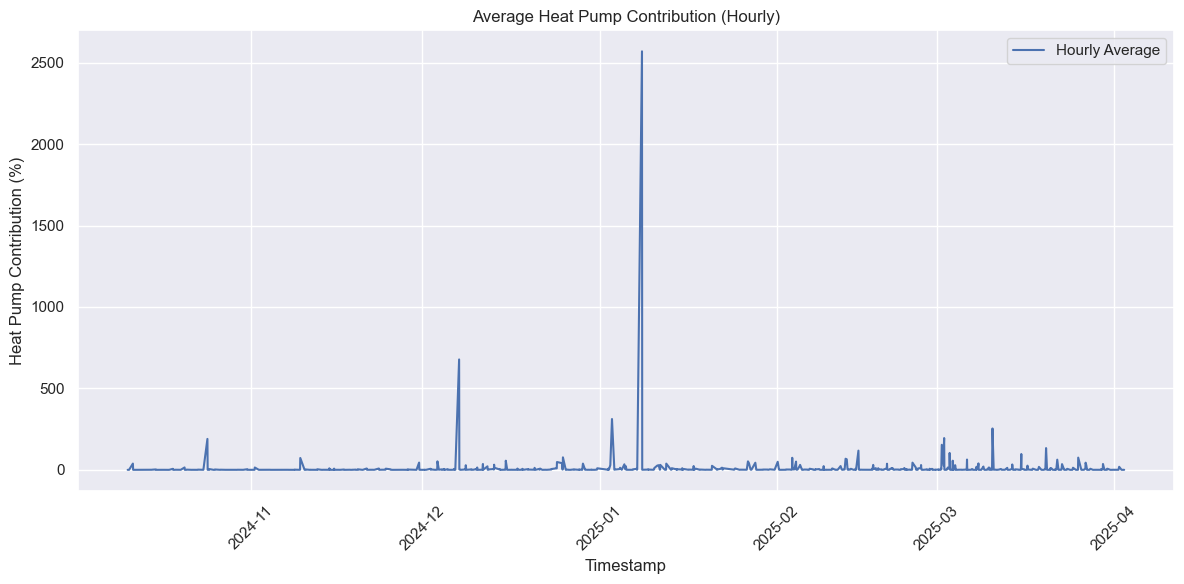

Hourly Heat Pump Contribution Summary:
count    1572.000000
mean        5.589875
std        68.891954
min         0.005312
25%         0.076213
50%         0.242016
75%         0.988628
max      2569.270004
Name: heatpump_pct, dtype: float64

Top 5 Peaks (Hourly):
                     timestamp  heatpump_pct
2160 2025-01-08 10:00:00+00:00   2569.270004
1392 2024-12-07 10:00:00+00:00    677.737330
2034 2025-01-03 04:00:00+00:00    311.972837
3632 2025-03-10 18:00:00+00:00    253.944489
3429 2025-03-02 07:00:00+00:00    195.033774


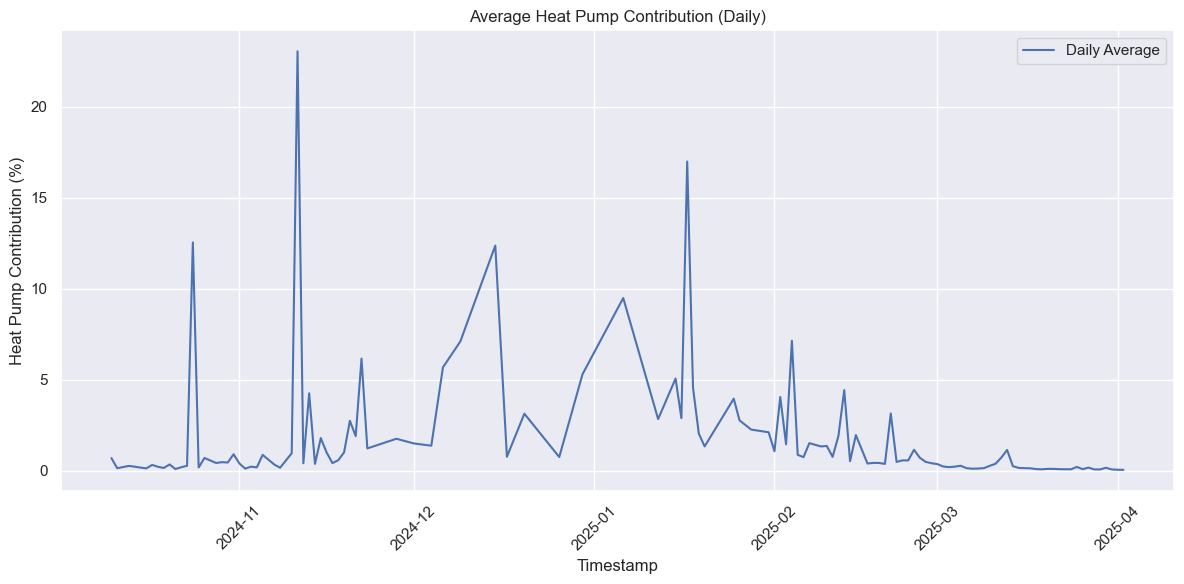


Daily Heat Pump Contribution Summary:
count    122.000000
mean       1.703037
std        3.274622
min        0.048356
25%        0.185593
50%        0.476130
75%        1.510498
max       23.033517
Name: heatpump_pct, dtype: float64

Top 5 Peaks (Daily):
                   timestamp  heatpump_pct
32 2024-11-11 00:00:00+00:00     23.033517
99 2025-01-17 00:00:00+00:00     16.983677
14 2024-10-24 00:00:00+00:00     12.538048
66 2024-12-15 00:00:00+00:00     12.364893
88 2025-01-06 00:00:00+00:00      9.486368


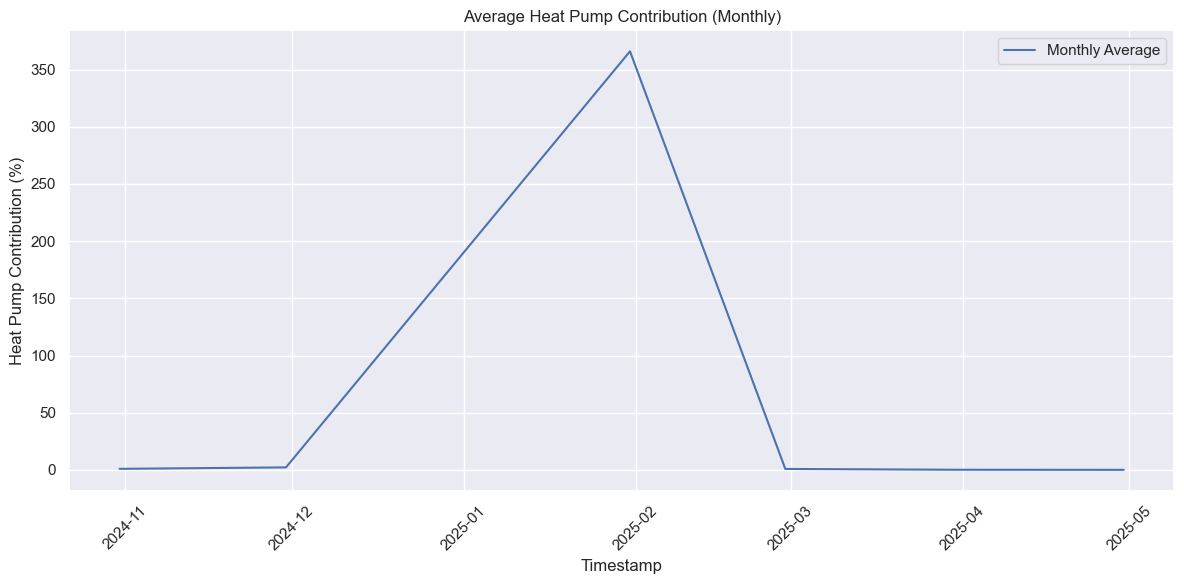


Monthly Heat Pump Contribution Summary:
count      6.000000
mean      61.676714
std      149.059805
min        0.051451
25%        0.305093
50%        0.873554
75%        1.873185
max      365.939724
Name: heatpump_pct, dtype: float64

Top 5 Peaks (Monthly):
                  timestamp  heatpump_pct
3 2025-01-31 00:00:00+00:00    365.939724
1 2024-11-30 00:00:00+00:00      2.190122
0 2024-10-31 00:00:00+00:00      0.922373
4 2025-02-28 00:00:00+00:00      0.824734
5 2025-03-31 00:00:00+00:00      0.131880


In [68]:
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly, x='timestamp', y='heatpump_pct', label='Hourly Average')
plt.title('Average Heat Pump Contribution (Hourly)')
plt.xlabel('Timestamp')
plt.ylabel('Heat Pump Contribution (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Print numerical summary
print("Hourly Heat Pump Contribution Summary:")
print(hourly['heatpump_pct'].describe())

print("\nTop 5 Peaks (Hourly):")
print(hourly[['timestamp', 'heatpump_pct']].sort_values(by='heatpump_pct', ascending=False).head())


# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily, x='timestamp', y='heatpump_pct', label='Daily Average')
plt.title('Average Heat Pump Contribution (Daily)')
plt.xlabel('Timestamp')
plt.ylabel('Heat Pump Contribution (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Print numerical summary
print("\nDaily Heat Pump Contribution Summary:")
print(daily['heatpump_pct'].describe())

print("\nTop 5 Peaks (Daily):")
print(daily[['timestamp', 'heatpump_pct']].sort_values(by='heatpump_pct', ascending=False).head())


# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly, x='timestamp', y='heatpump_pct', label='Monthly Average')
plt.title('Average Heat Pump Contribution (Monthly)')
plt.xlabel('Timestamp')
plt.ylabel('Heat Pump Contribution (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Print numerical summary
print("\nMonthly Heat Pump Contribution Summary:")
print(monthly['heatpump_pct'].describe())

print("\nTop 5 Peaks (Monthly):")
print(monthly[['timestamp', 'heatpump_pct']].sort_values(by='heatpump_pct', ascending=False).head())


# Energy Consumption Analysis Report

### Overview

This report analyzes the contribution of heat pump energy consumption as a percentage of the total facility energy usage. The analysis is conducted across different time scales: hourly, daily, and monthly. Additionally, location-based boxplots and a time-series comparison of total heat pump energy versus total facility energy are presented. A 24-hour rolling average is also used to highlight temporal trends and potential anomalies.

### 1. Hourly Heat Pump Contribution
#### Summary Statistics

- **Count**: 1,572 hourly intervals
- **Mean**: 5.59%
- **Standard Deviation**: 68.89%
- **Minimum**: 0.0053%
- **25th Percentile**: 0.0762%
- **Median (50th Percentile)**: 0.2420%
- **75th Percentile**: 0.9886%
- **Maximum**: 2,569.27%

#### Top 5 Hourly Peaks

| Timestamp                   | Heat Pump Contribution (%) |
|:----------------------------|:----------------------------|
| 2025-01-08 10:00:00+00:00  | 2,569.27%                   |
| 2024-12-07 10:00:00+00:00  | 677.74%                     |
| 2025-01-03 04:00:00+00:00  | 311.97%                     |
| 2025-03-10 18:00:00+00:00  | 253.94%                     |
| 2025-03-02 07:00:00+00:00  | 195.03%                     |

### Analysis

- The hourly aggregated data shows significant peaks, with the maximum heat pump contribution reaching over **2,500%**.
- The high standard deviation of **68.89%** reflects considerable variation in contributions, from minimal to extreme values.
- The median value of **0.24%** suggests that the heat pump’s contribution is generally low for most hours, but these extreme peaks indicate occasional spikes in usage.

### 2. Daily Heat Pump Contribution
#### Summary Statistics

- **Count**: 122 days
- **Mean**: 1.70%
- **Standard Deviation**: 3.27%
- **Minimum**: 0.0484%
- **25th Percentile**: 0.1856%
- **Median (50th Percentile)**: 0.4761%
- **75th Percentile**: 1.5105%
- **Maximum**: 23.03%

#### Top 5 Daily Peaks

| Timestamp                   | Heat Pump Contribution (%) |
|:----------------------------|:----------------------------|
| 2024-11-11 00:00:00+00:00  | 23.03%                      |
| 2025-01-17 00:00:00+00:00  | 16.98%                      |
| 2024-10-24 00:00:00+00:00  | 12.54%                      |
| 2024-12-15 00:00:00+00:00  | 12.36%                      |
| 2025-01-06 00:00:00+00:00  | 9.49%                       |

### Analysis

- The daily summary shows more variability, with the maximum heat pump contribution reaching **23.03%** on 2024-11-11.
- The median of **0.476%** reflects a general trend of very low daily contributions, but with a few days showing notably higher values.
- The high standard deviation of **3.27%** further emphasizes the fluctuation in daily contributions.

### 3. Monthly Heat Pump Contribution
#### Summary Statistics

- **Count**: 6 months
- **Mean**: 61.68%
- **Standard Deviation**: 149.06%
- **Minimum**: 0.0515%
- **25th Percentile**: 0.3051%
- **Median (50th Percentile)**: 0.8736%
- **75th Percentile**: 1.8732%
- **Maximum**: 365.94%

#### Top 5 Monthly Peaks

| Timestamp                   | Heat Pump Contribution (%) |
|:----------------------------|:----------------------------|
| 2025-01-31 00:00:00+00:00  | 365.94%                     |
| 2024-11-30 00:00:00+00:00  | 2.19%                       |
| 2024-10-31 00:00:00+00:00  | 0.92%                       |
| 2025-02-28 00:00:00+00:00  | 0.82%                       |
| 2025-03-31 00:00:00+00:00  | 0.13%                       |

### Analysis

- The monthly data shows an extremely high peak in January 2025, with a contribution of **365.94%**.
- The mean of **61.68%** is heavily influenced by this peak, while the median of **0.87%** remains much lower.
- The high standard deviation of **149.06%** further indicates that monthly contributions are highly variable, with several months showing negligible contributions.

---

# Energy Consumption Breakdown Report

## Overview
This analysis examines the **relative contributions** of various energy sources at the facility:

- Heat Pump
- Load Power
- Battery Power
- Purchased Power

This breakdown provides insights into potential areas for **efficiency improvements** and **energy cost savings**.

---

## Energy Consumption Breakdown

| Energy Source     | Contribution (%) |
|-------------------|------------------|
| Heat Pump         | **0.03%**         |
| Load Power        | **52.75%**        |
| Battery Power     | **1.05%**         |
| Purchased Power   | **46.17%**        |

---

## Key Observations

### **Predominance of Load Power**
- Load power comprises the **largest share (52.75%)**, likely representing the **general facility operations** or other non-heat-pump loads.
- This suggests that **most energy use is unrelated to the heat pump**.

### **High Purchased Power Share**
- Purchased power contributes **46.17%** to total consumption, indicating heavy reliance on external energy. This raises concerns about:
  - **Energy efficiency**
  - **Operational costs**
  - **Sustainability goals**
- There is an opportunity to increase **self-generation** via heat pump or renewable sources.

### **Minimal Heat Pump Contribution**
- The heat pump's contribution is only **0.03%**, which is unexpectedly low. This could be due to:
  - **Data inconsistency** — Energy readings may be incorrect or misrecorded.
  - **Underutilization** — The heat pump may not be fully utilized.
  - **Energy mix imbalance** — Other sources may overshadow the heat pump's usage.

### **Low Battery Power Utilization**
- Battery power contributes just **1.05%**, suggesting that batteries are likely used **primarily for backup** rather than optimally for energy management.

---

## Potential Areas for Further Investigation

### Investigate Heat Pump Performance
- Validate if the heat pump is:
  - **Properly scheduled and utilized** during optimal times.
  - **Malfunctioning or underperforming**.
  - **Correctly metered** in the energy tracking system.

### Optimize Energy Mix
- Investigate opportunities to:
  - **Increase heat pump usage** to offset purchased energy.
  - **Incorporate renewable sources**, e.g., **solar PV**.
  - Analyze **time-of-use rates** to better manage costs.

### Improve Battery Utilization Strategy
- Optimize battery usage by:
  - Charging during **off-peak pricing hours**.
  - Discharging during **peak demand periods**.
  - Enhancing battery participation in **demand response programs**.

---

## Conclusion

The facility currently relies heavily on **load power (52.75%)** and **purchased energy (46.17%)**, while **heat pump and battery contributions remain minimal**.

This report reveals **significant opportunities** to:
- Reassess **heat pump effectiveness** and improve operational use.
- Leverage **battery systems more effectively**.
- Strategically adjust the **energy mix** for cost savings and sustainability.

With targeted improvements, the facility can **greatly enhance energy efficiency** and reduce dependency on external sources.

---


### Bar Chart for Percentage Distribution (Energy Consumption Categories)

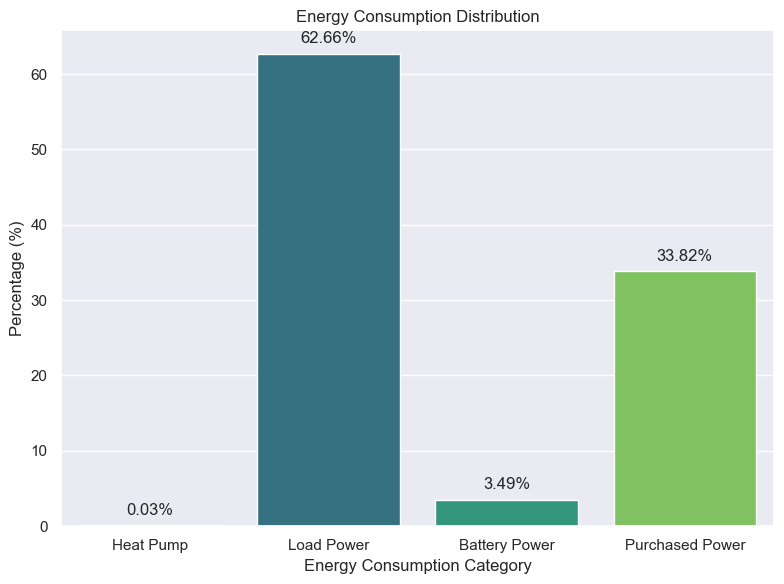

Energy Consumption Breakdown:
Heat Pump: 0.03%
Load Power: 62.66%
Battery Power: 3.49%
Purchased Power: 33.82%


In [ ]:
# Calculate total energy consumption across all columns
total_energy = combined_df['total_energy_kWh'].sum()
load_energy = combined_df['load_power'].sum()
battery_energy = combined_df['battery_discharging_power'].sum()
purchased_energy = combined_df['purchased_power'].sum()

# Calculate the heat pump energy
heat_pump_energy = combined_df['total_energy_kWh'].sum()

# Total energy
total_consumption = total_energy + load_energy + battery_energy + purchased_energy

# Calculate the percentage share of each category
heat_pump_pct = (heat_pump_energy / total_consumption) * 100
load_pct = (load_energy / total_consumption) * 100
battery_pct = (battery_energy / total_consumption) * 100
purchased_pct = (purchased_energy / total_consumption) * 100

# Create a list of categories and their respective percentages
categories = ['Heat Pump', 'Load Power', 'Battery Power', 'Purchased Power']
percentages = [heat_pump_pct, load_pct, battery_pct, purchased_pct]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=percentages, palette='viridis')
plt.title('Energy Consumption Distribution')
plt.xlabel('Energy Consumption Category')
plt.ylabel('Percentage (%)')

# Adding numerical values on top of the bars
for i, p in enumerate(percentages):
    plt.text(i, p + 1, f'{p:.2f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Print the numerical values for easy reference
print("Energy Consumption Breakdown:")
print(f"Heat Pump: {heat_pump_pct:.2f}%")
print(f"Load Power: {load_pct:.2f}%")
print(f"Battery Power: {battery_pct:.2f}%")
print(f"Purchased Power: {purchased_pct:.2f}%")


# Energy Consumption Breakdown Report

## Overview
The energy consumption across various categories at the facility has been analyzed to understand the **relative contributions** of:

- Heat Pump
- Load Power
- Battery Power
- Purchased Power

This breakdown helps identify potential areas for **efficiency improvements** and energy cost savings.

---

## Energy Consumption Breakdown

| Energy Source     | Contribution (%) |
|-------------------|------------------|
|  Heat Pump        | **0.03%**         |
|  Load Power       | **62.66%**        |
|  Battery Power    | **3.49%**         |
|  Purchased Power  | **33.82%**        |

---

## Key Observations

### **Predominance of Load Power**
- Load power makes up the **largest share at 62.66%**.
- Likely represents the **general facility operations** or other non-heat-pump loads.
- Indicates that **most energy use is unrelated to the heat pump**.

### **High Purchased Power Share**
- Purchased power contributes **33.82%** to total consumption.
- This **heavy reliance on external energy** raises concerns about:
  - **Energy efficiency**
  - **Operational costs**
  - **Sustainability goals**
- May suggest room for **increased self-generation** via heat pump or renewables.

### **Minimal Heat Pump Contribution**
- At **only 0.03%**, the heat pump plays an **unexpectedly small role**.
- This could indicate:
  -  **Data inconsistency** – Energy readings may be incorrect or misrecorded.
  -  **Underutilization** – Heat pump not used to its full capacity.
  -  **Energy mix imbalance** – Other sources may overshadow its usage.

### **Low Battery Power Utilization**
- Battery power contributes just **3.49%**, suggesting:
  - Batteries may be used **primarily for backup**.
  - Or possibly not **strategically leveraged** (e.g., for peak shaving or load shifting).

---

## Potential Areas for Further Investigation

### Investigate Heat Pump Performance
- Validate if the heat pump is:
  - **Properly scheduled and utilized** during optimal times.
  - **Malfunctioning or underperforming**.
  - **Correctly metered** in the energy tracking system.

### Optimize Energy Mix
- With **33.82% of energy purchased**, investigate opportunities to:
  - **Increase heat pump usage** to offset purchased energy.
  - **Incorporate renewable sources**, e.g., **solar PV**.
  - Analyze **time-of-use rates** to better manage costs.

### Improve Battery Utilization Strategy
- Increase battery value by:
  - Charging during **off-peak pricing hours**.
  - Discharging during **peak demand periods**.
  - Enhancing battery participation in **demand response programs**.

---

## Conclusion

The facility currently relies heavily on **load power (62.66%)** and **purchased energy (33.82%)**, while **heat pump and battery contributions remain minimal**.

This report reveals **significant opportunities** to:

- Reassess **heat pump effectiveness** and improve operational use.
- Leverage **battery systems more effectively**.
- Strategically adjust the **energy mix** for cost savings and sustainability.

With proper attention and targeted adjustments, the facility can **greatly improve energy efficiency** and reduce dependency on external sources.

---


### Boxplot for Heat Pump Contribution Across Locations

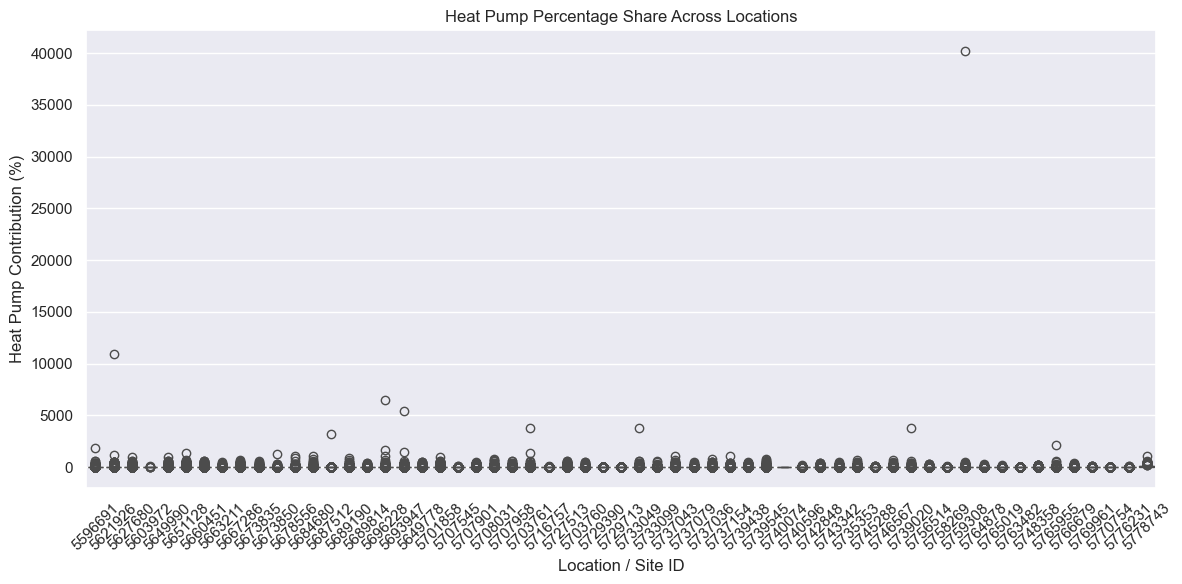

Heat Pump Contribution Across Locations:
           count        mean         std       min        25%         50%  \
site_id                                                                     
5596691  14181.0    1.953097   23.292014  0.000000   0.014950    0.068786   
5603972     39.0    2.984694   14.808913  0.021399   0.052980    0.095797   
5621926  13915.0    3.912276   95.623939  0.000000   0.021937    0.096685   
5627680  13681.0    3.990568   26.670051  0.000000   0.019861    0.085140   
5649778  13570.0    2.758839   17.995790  0.000000   0.023506    0.129392   
5649990  14688.0    3.047741   23.319446  0.000000   0.011406    0.063384   
5651128  14956.0    4.412820   32.113992 -0.000000   0.017348    0.075445   
5660451   8519.0    3.043578   24.476927  0.000000   0.007383    0.064534   
5663211  12471.0    1.360949   12.965152  0.000000   0.006618    0.033518   
5667286  17396.0    2.048179   18.278013  0.000000   0.013683    0.084090   
5673835   9158.0    1.608384   14.5

In [70]:
# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='site_id', y='heatpump_pct')
plt.title('Heat Pump Percentage Share Across Locations')
plt.xlabel('Location / Site ID')
plt.ylabel('Heat Pump Contribution (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print numerical summaries per location
location_summary = combined_df.groupby('site_id')['heatpump_pct'].describe()
print("Heat Pump Contribution Across Locations:")
print(location_summary)

print("\nTop 5 Locations by Median Heat Pump Contribution:")
print(location_summary.sort_values(by='50%', ascending=False).head())


# Heat Pump Contribution Across Locations (Boxplot Analysis)

## Summary by Location

This section examines the distribution of heat pump contributions by location, using a combination of grouped summary statistics and boxplot visualizations.

Key findings include:

- **Prevalence of Zero Medians**  
    Many sites exhibit a median contribution of 0%. This either reflects minimal or no actual usage of the heat pump, or issues in data quality—particularly frequent zero values in the denominator (e.g., `active_power`).

- **Presence of Extreme Values**  
    Some locations show highly skewed distributions, with a significant spread in the data. Notably, certain sites exhibit extreme maximum values (e.g., 1896.06% contribution at site 5596691). These outliers can skew the overall interpretation of the contribution of heat pumps.

- **Illustrative Case – Site 5596691**  
    This location shows a median contribution of 0% but also has a high standard deviation (23.29%) and a maximum contribution of 1896.06%. These numbers suggest that there might be operational inconsistencies or data issues at this site, potentially caused by zero values in the active_power field or irregular data recording.

---

## Analysis

### 1. Consistently Low Contribution

Locations with a median contribution of zero should be further evaluated for one or more of the following reasons:

- **Operational Status**: The heat pump might not be in use or may not be required at that specific facility.
- **Data Artifacts**: Repeated zero readings in `active_power` can lead to division by zero during percentage calculations.
- **Sensor or Logging Errors**: Data might be missing or misrecorded, affecting the reliability of energy consumption readings.

For instance, Site 5596691 shows a median contribution of 0% but a wide range of values (min = 0, max = 1896.06). This suggests data inconsistencies rather than a genuine lack of heat pump usage.

### 2.Anomalies in the Data:

The dataset no longer contains negative values for heat pump contributions, which were previously a concern for calculation instability and potential outliers. However, extreme values still exist, and certain sites display significant variability.

Key observations:

- **Extreme Values**: Some locations, such as Site 5759308 (with a max contribution of 40179.46%), still show high contributions compared to others, suggesting possible anomalies that need to be examined.

- **High Variability**: Sites like Site 575930 exhibit a very high standard deviation (459.30%), indicating a high degree of variability that may require further inspection. This variability could be due to data quality issues.

---


### Time-Series Plot for Total Heat Pump Energy and Total Facility Energy Over Time

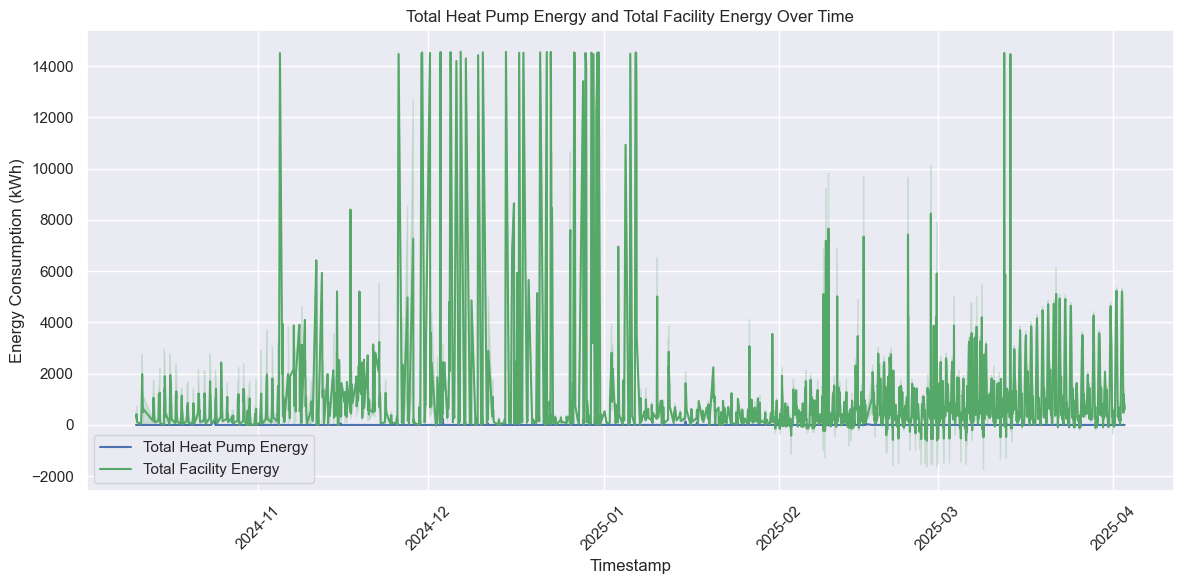

Total Heat Pump vs Facility Energy Summary (Daily Aggregated):
       total_energy_kWh  active_power
count        176.000000  1.760000e+02
mean        3197.336654  5.059095e+06
std         4186.526445  1.053053e+07
min            0.000000  0.000000e+00
25%          154.922187  6.911300e+04
50%          631.811889  2.187320e+05
75%         6173.954095  3.760760e+06
max        20242.919811  4.980611e+07

Top 5 Days with Highest Heat Pump Energy:
                    timestamp  total_energy_kWh
97  2025-01-15 00:00:00+00:00      20242.919811
162 2025-03-21 00:00:00+00:00      15466.818953
154 2025-03-13 00:00:00+00:00      13938.263239
158 2025-03-17 00:00:00+00:00      13385.090283
157 2025-03-16 00:00:00+00:00      12521.252530

Top 5 Days with Highest Facility Energy:
                    timestamp  active_power
173 2025-04-01 00:00:00+00:00    49806113.0
174 2025-04-02 00:00:00+00:00    43972315.0
172 2025-03-31 00:00:00+00:00    40861823.0
162 2025-03-21 00:00:00+00:00    39996478.0
16

In [71]:
# Plot
plt.figure(figsize=(12, 6))

# Heat Pump Energy
sns.lineplot(data=combined_df, x='timestamp', y='total_energy_kWh', label='Total Heat Pump Energy', color='b')

# Facility Energy
sns.lineplot(data=combined_df, x='timestamp', y='active_power', label='Total Facility Energy', color='g')

# Labels and title
plt.title('Total Heat Pump Energy and Total Facility Energy Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Resample and print daily stats
ts_energy = combined_df.set_index('timestamp')[['total_energy_kWh', 'active_power']].resample('D').sum().reset_index()

print("Total Heat Pump vs Facility Energy Summary (Daily Aggregated):")
print(ts_energy.describe())

print("\nTop 5 Days with Highest Heat Pump Energy:")
print(ts_energy[['timestamp', 'total_energy_kWh']].sort_values(by='total_energy_kWh', ascending=False).head())

print("\nTop 5 Days with Highest Facility Energy:")
print(ts_energy[['timestamp', 'active_power']].sort_values(by='active_power', ascending=False).head())


# Total Energy Comparison Over Time

## Daily Aggregated Energy Summary

This section provides a comparative overview of total facility energy consumption and heat pump energy consumption at a daily aggregation level. The aim is to understand the scale differences, variation, and identify potential anomalies within the energy usage data after the recent cleaning and validation process.

---

### Updated Key Numerical Insights

#### Heat Pump Energy Consumption (Daily Aggregated)
- **Count:** 176 days  
- **Mean:** ~3,197 kWh  
- **Standard Deviation:** ~4,187 kWh  
- **Median (50%):** ~632 kWh  
- **Range:** 0 kWh to ~20,243 kWh  

#### Facility Total Energy Consumption (Active Power - Daily Aggregated)
- **Count:** 176 days  
- **Mean:** ~5,059,095 kWh (or equivalent metric units)  
- **Standard Deviation:** ~10,530,530 kWh  
- **Median (50%):** ~218,732 kWh  
- **Range:** 0 kWh to ~49,806,113 kWh

#### Top 5 Days with Highest Heat Pump Energy:
| Date                          | Heat Pump Consumption (kWh) |
|-------------------------------|-----------------------------|
| 2025-01-15                    | 20,243.92                   |
| 2025-03-21                    | 15,466.82                   |
| 2025-03-13                    | 13,938.26                   |
| 2025-03-17                    | 13,385.09                   |
| 2025-03-16                    | 12,521.25                   |

#### Top 5 Days with Highest Facility Energy:
| Date                          | Facility Energy (active power) |
|-------------------------------|--------------------------------|
| 2025-04-01                    | 49,806,113                     |
| 2025-04-02                    | 43,972,315                     |
| 2025-03-31                    | 40,861,823                     |
| 2025-03-21                    | 39,996,478                     |
| 2025-03-23                    | 39,515,147                     |

---

## Analysis

### Disparity in Energy Scales

The new data reinforces the earlier observation that there is a **substantial gap** between heat pump consumption and overall facility consumption:

- **Heat Pump Contribution:** With a daily mean of approximately 3,197 kWh and median around 632 kWh, heat pump energy usage remains a minor component of the total daily energy recorded.
- **Facility Total Energy:** The total facility energy, with its mean in the millions of kWh, underscores that most energy demand is met by other consumption sources, such as load power, purchased energy, and battery operations.

This numerical disparity confirms that, even after cleaning, the heat pump only contributes a small percentage relative to the overall energy usage. The large standard deviations in both datasets suggest significant variability, which might be due to operational fluctuations or remaining data inconsistencies.

### Potential Data Anomalies and Outliers

- **High Facility Energy Values:** The peak facility energy readings—reaching nearly 50 million kWh on some days—are still extraordinarily high and may indicate:
  - **Data Quality Issues:** Possibilities include data entry errors, unit mismatches, or recording mistakes.
  - **Aggregation Irregularities:** There might be duplicate aggregation or overlapping records for specific dates.
  
- **Heat Pump Peaks:** While the upper limit for heat pump consumption (20,243 kWh) is much lower compared to the facility totals, days with exceptionally high values (as observed in the top 5 list) should be examined to ensure they aren’t caused by faulty measurement or outlier events that could skew subsequent analysis.


---

## Conclusion

The refined daily energy summary underscores:
- A **marked disparity** between the minor daily contribution of heat pumps and the vast scale of total facility energy usage.
- Persistent data anomalies, particularly in the facility energy readings, that need further investigation through threshold checks, sub-component analysis, and enhanced outlier detection.
- The necessity to employ advanced visualization techniques to better understand and communicate the underlying trends and outliers across the datasets.

---


### Highlighting Trends, Outliers, or Temporal Patterns

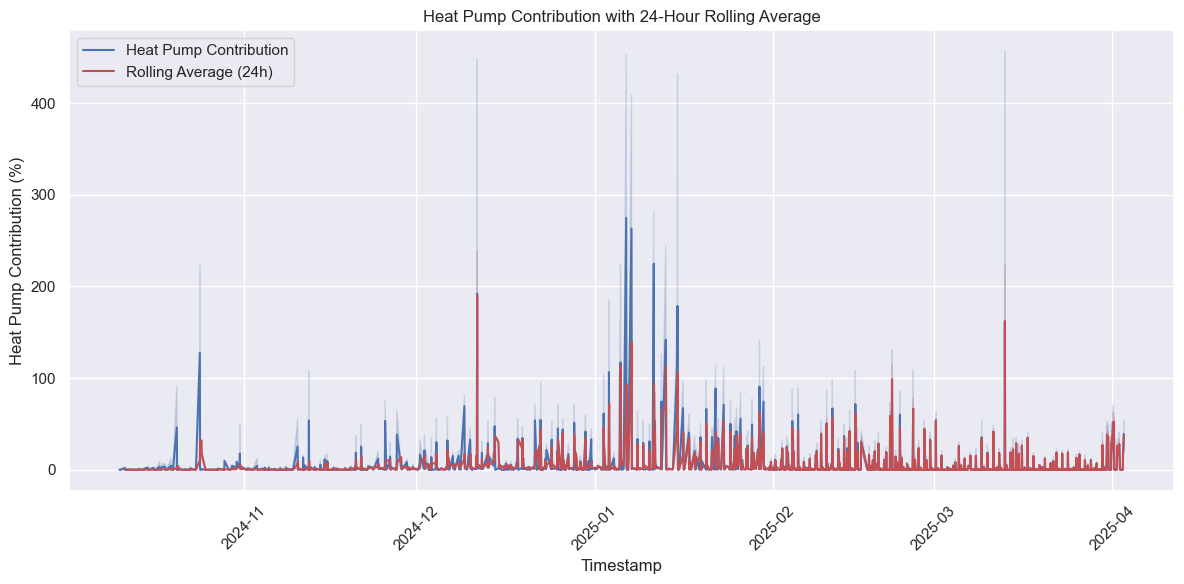

Rolling Average of Heat Pump Contribution (24-hour window):
        heatpump_pct    rolling_avg
count  525514.000000  525514.000000
mean        2.339668       2.339041
std        62.677382      15.422237
min         0.000000      -0.000000
25%         0.011339       0.037189
50%         0.060201       0.122597
75%         0.242993       0.562161
max     40179.458721    1720.282471

Top 5 Highest Rolling Averages:
                        timestamp  heatpump_pct  rolling_avg
2867368 2025-03-13 08:00:00+00:00      0.006724  1720.282471
2867375 2025-03-13 08:00:00+00:00      0.021604  1720.282295
2867575 2025-03-13 08:00:00+00:00      0.010995  1720.281931
2867726 2025-03-13 08:00:00+00:00      1.094573  1720.281650
2867376 2025-03-13 08:00:00+00:00      0.044463  1720.275898


In [72]:
# Ensure rolling average exists
combined_df['rolling_avg'] = combined_df['heatpump_pct'].rolling(window=24).mean()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='timestamp', y='heatpump_pct', label='Heat Pump Contribution')
sns.lineplot(data=combined_df, x='timestamp', y='rolling_avg', label='Rolling Average (24h)', color='r')
plt.title('Heat Pump Contribution with 24-Hour Rolling Average')
plt.xlabel('Timestamp')
plt.ylabel('Heat Pump Contribution (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Drop NaNs and print summary
rolling = combined_df[['timestamp', 'heatpump_pct', 'rolling_avg']].dropna()

print("Rolling Average of Heat Pump Contribution (24-hour window):")
print(rolling.describe())

print("\nTop 5 Highest Rolling Averages:")
print(rolling.sort_values(by='rolling_avg', ascending=False).head())


# Rolling Average of Heat Pump Contribution

## Overview

This section presents a statistical summary of the 24-hour rolling average of heat pump energy contribution to total facility energy. Rolling averages help reduce short-term volatility and reveal underlying trends in energy performance.

---

## Summary Statistics (24-Hour Rolling Average)

- **Total Records Analyzed**: 525,514  
- **Mean (Raw Heat Pump Contribution %)**: 2.34%  
- **Mean (24h Rolling Average %)**: 2.34%  
- **Standard Deviation (Raw Contribution)**: 62.68  
- **Standard Deviation (Rolling Average)**: 15.42  
- **Minimum Values**: 0.00% for both raw and rolling values  
- **25th Percentile (Raw/Rolling)**: ~0.01% / 0.04%  
- **Median (50th Percentile) (Raw/Rolling)**: ~0.06% / 0.12%  
- **75th Percentile (Raw/Rolling)**: ~0.24% / 0.56%  
- **Maximum Values**: 40,179.46% (raw), 1,720.28% (rolling)

These statistics illustrate that the bulk of the data settles at very low percentage contributions, with medians around 0.06–0.12%. However, the presence of extreme maximum values—even within the rolling window—suggests occasional severe outlier events that could be due to sensor errors, unit mismatches, or calculation issues.

---

## Top 5 Highest Rolling Averages

| Timestamp                      | Heat Pump Contribution (%) | Rolling Average (%) |
|--------------------------------|----------------------------:|--------------------:|
| 2025-03-13 08:00:00+00:00       | 0.006724                   | 1,720.282471        |
| 2025-03-13 08:00:00+00:00       | 0.021604                   | 1,720.282295        |
| 2025-03-13 08:00:00+00:00       | 0.010995                   | 1,720.281931        |
| 2025-03-13 08:00:00+00:00       | 1.094573                   | 1,720.281650        |
| 2025-03-13 08:00:00+00:00       | 0.044463                   | 1,720.275898        |

*Note: The identical timestamps suggest that these outlier rolling averages are concentrated in a very short period, which warrants a closer review of the underlying data for that interval.*

---

## Analytical Observations

### 1. **Smoothing Effect vs. Data Noise**

- **Purpose of Rolling Averages:**  
  The 24-hour rolling average is designed to smooth out short-term fluctuations, making it easier to identify longer-term trends in heat pump energy contribution.
  
- **Current Findings:**  
  While most data points stabilize at low contribution percentages (with medians around 0.12%), the influence of extreme outliers is still evident in the high maximum values recorded. These outliers increase the rolling average significantly on select occasions, suggesting that the rolling window is capturing occasional, dramatic data anomalies.

### 2. **Presence of Outliers**

- **Extreme Maximum Values:**  
  With maximum rolling averages reaching approximately 1,720%, such values are not plausible under normal operational conditions and indicate severe data anomalies.
  
- **Potential Causes:**  
  These extreme values may be due to:
  - Division by near-zero or zero total energy values.
  - Spikes or errors in sensor readings.
  - Unit conversion errors or misconfigured calculations.
  
- **Interpretation:**  
  The drastic difference between central tendency measures (median near 0.12%) and the maximum value points to a generally stable system with rare, disruptive erroneous records.

### 3. **Negative or Zero Contributions**

- **Zero Values:**  
  The minimum for both raw contributions and rolling averages is 0%, which likely reflects periods where either the heat pump was inactive or the contribution was too low to measure accurately.

---

## Conclusion

The cleaned data provides a view of the heat pump contribution. While most observations show very modest contributions (median near 0.12%), the occurrence of extreme outlier events—evidenced by rolling averages spiking to over 1,700%—indicates that data integrity issues exists. By incorporating advanced outlier detection techniques, revalidating metric definitions, and refining the rolling average calculations, we can achieve a more reliable and interpretable analysis of heat pump performance.


# Overall Conclusions and Recommendations

## Summary of Findings

### Data Quality Considerations

- **Extreme Outliers in Contribution Metrics**:
  - The cleaned dataset confirms that the bulk of heat pump contribution values are very low—with medians around **0.06% (raw)** and **0.12% (24h rolling average)**.
  - Nonetheless, a minority of records exhibit extreme outlier values (up to **40,179%** in raw calculations and **1,720%** in the 24-hour rolling averages). These rare but dramatic spikes suggest occasional issues—such as residual effects of division by near-zero denominators, sensor misreadings, or unit inconsistencies—that require further attention.

- **Resolution of Negative and Infinite Values**:
  - The data cleaning process systematically replaces negative and infinite values with NaNs and removes affected rows, ensuring that subsequent analysis uses only valid, non-negative contribution percentages.

---

### Heat Pump Contribution Patterns

- **Central Tendency vs. Extreme Variations**:
  - Aggregated by hourly, daily, and monthly intervals, the median heat pump contributions remain low, indicating that—under normal operation—the heat pump contributes minimally to total facility energy.
  - However, occasional spike periods—with contributions soaring to thousands of percentage points—suggest that these extreme values are more likely due to data anomalies rather than genuine operational demands.

- **Interpretation Ambiguity**:
  - While low median values may imply that the heat pump’s true operational impact is minimal, they might also indicate underreporting or gaps in data collection. This ambiguity calls for a careful review of measurement logic and sensor calibration.

---

### Location-Based Variability

- **Inconsistent Sensor Readings**:
  - Many locations display a consistent near-zero median heat pump contribution, while a subset records extreme outlier events.
  - Such variability can arise from:
    - Genuine operational differences in HVAC and heat pump usage.
    - Sensor calibration issues, intermittent data loss, or unit conversion discrepancies.
    - Temporal misalignments in metered data (e.g., zero or near-zero `active_power` values leading to disproportionate percentage calculations).

- **Recommendation for Site-Level Audits**:
  - Conducting a detailed audit at the facility level is essential. This analysis should determine whether high outlier events are linked to valid operational scenarios or stem from underlying data quality issues.

---

## Final Thoughts

The current dataset provides a **rich foundation** for energy usage analysis but still reveals critical anomalies—particularly the sporadic, extreme rolling average values. Although the overall median contributions suggest minimal operational impact from heat pumps, the presence of significant outliers underscores the need for ongoing data quality checks and process refinements. 

By combining enhanced data cleaning, granular facility-level analysis, robust predictive modeling, and advanced visualizations, we can transition from reactive troubleshooting to proactive energy optimization and anomaly detection. A strategic integration of engineering expertise, data science methods, and operational insights will be instrumental in unlocking the full potential of the energy dataset and driving informed decisions for system improvements.


#### Save the dataset to be used with **rest api** (app.py), **RL_Model** (RL_Model.ipynb) and **Prophet** (Prophet.ipynb)

In [73]:
# Save the fully processed and clean dataset
combined_df.to_parquet("./Data/combined_dataset.parquet", index=False)